In [1]:
import pandas as pd 
import numpy as np 
import dcor
from collections import defaultdict
from math import log10
from scipy import stats as sps
from bisect import bisect_right
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('nba_game_df.csv')
pd.set_option('display.max_columns', None)
df.head(2)
df['date'] = pd.to_datetime(df['date'])

In [3]:
match = df[(df['date'] == pd.to_datetime('2024-03-28'))]
match

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_3P%_basic_max,Team_A_3P%_basic_totals,Team_A_3PA_basic_max,Team_A_3PA_basic_totals,Team_A_3PAr_advanced_max,Team_A_3PAr_advanced_totals,Team_A_3P_basic_max,Team_A_3P_basic_totals,Team_A_AST%_advanced_max,Team_A_AST%_advanced_totals,Team_A_AST_basic_max,Team_A_AST_basic_totals,Team_A_BLK%_advanced_max,Team_A_BLK%_advanced_totals,Team_A_BLK_basic_max,Team_A_BLK_basic_totals,Team_A_DRB%_advanced_max,Team_A_DRB%_advanced_totals,Team_A_DRB_basic_max,Team_A_DRB_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_max,Team_A_FG%_basic_totals,Team_A_FGA_basic_max,Team_A_FGA_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_FT%_basic_max,Team_A_FT%_basic_totals,Team_A_FTA_basic_max,Team_A_FTA_basic_totals,Team_A_FT_basic_max,Team_A_FT_basic_totals,Team_A_FTr_advanced_max,Team_A_FTr_advanced_totals,Team_A_GmSc_basic_max,Team_A_MP_advanced_totals,Team_A_ORB%_advanced_max,Team_A_ORB%_advanced_totals,Team_A_ORB_basic_max,Team_A_ORB_basic_totals,Team_A_ORtg_advanced_max,Team_A_ORtg_advanced_totals,Team_A_PF_basic_max,Team_A_PF_basic_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q2,Team_A_Q3,Team_A_Q4,Team_A_STL%_advanced_max,Team_A_STL%_advanced_totals,Team_A_STL_basic_max,Team_A_STL_basic_totals,Team_A_TOV%_advanced_max,Team_A_TOV%_advanced_totals,Team_A_TOV_basic_max,Team_A_TOV_basic_totals,Team_A_TRB%_advanced_max,Team_A_TRB%_advanced_totals,Team_A_TRB_basic_max,Team_A_TRB_basic_totals,Team_A_TS%_advanced_max,Team_A_TS%_advanced_totals,Team_A_USG%_advanced_max,Team_A_eFG%_advanced_max,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3P%_basic_max,Team_B_3P%_basic_totals,Team_B_3PA_basic_max,Team_B_3PA_basic_totals,Team_B_3PAr_advanced_max,Team_B_3PAr_advanced_totals,Team_B_3P_basic_max,Team_B_3P_basic_totals,Team_B_AST%_advanced_max,Team_B_AST%_advanced_totals,Team_B_AST_basic_max,Team_B_AST_basic_totals,Team_B_BLK%_advanced_max,Team_B_BLK%_advanced_totals,Team_B_BLK_basic_max,Team_B_BLK_basic_totals,Team_B_DRB%_advanced_max,Team_B_DRB%_advanced_totals,Team_B_DRB_basic_max,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_max,Team_B_FG%_basic_totals,Team_B_FGA_basic_max,Team_B_FGA_basic_totals,Team_B_FG_basic_max,Team_B_FG_basic_totals,Team_B_FT%_basic_max,Team_B_FT%_basic_totals,Team_B_FTA_basic_max,Team_B_FTA_basic_totals,Team_B_FT_basic_max,Team_B_FT_basic_totals,Team_B_FTr_advanced_max,Team_B_FTr_advanced_totals,Team_B_GmSc_basic_max,Team_B_MP_advanced_totals,Team_B_ORB%_advanced_max,Team_B_ORB%_advanced_totals,Team_B_ORB_basic_max,Team_B_ORB_basic_totals,Team_B_ORtg_advanced_max,Team_B_ORtg_advanced_totals,Team_B_PF_basic_max,Team_B_PF_basic_totals,Team_B_PTS_basic_max,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_Q2,Team_B_Q3,Team_B_Q4,Team_B_STL%_advanced_max,Team_B_STL%_advanced_totals,Team_B_STL_basic_max,Team_B_STL_basic_totals,Team_B_TOV%_advanced_max,Team_B_TOV%_advanced_totals,Team_B_TOV_basic_max,Team_B_TOV_basic_totals,Team_B_TRB%_advanced_max,Team_B_TRB%_advanced_totals,Team_B_TRB_basic_max,Team_B_TRB_basic_totals,Team_B_TS%_advanced_max,Team_B_TS%_advanced_totals,Team_B_USG%_advanced_max,Team_B_eFG%_advanced_max,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game
70,0,1,ATL_vs_BOS,2024-03-28,3.0,0.556,0.341,19.0,44.0,0.833,0.423,6.0,15.0,25.9,47.1,7.0,24.0,5.5,8.6,2.0,5.0,32.5,80.0,11.0,36.0,126.0,119.6,1.0,0.490,44.0,104.0,18.0,51.0,1.0,0.600,4.0,10.0,4.0,6.0,0.333,0.096,26.3,265.0,21.9,33.3,7.0,17.0,212.0,120.6,6.0,17.0,44.0,123.0,28,31,30,23,2.6,4.9,2.0,5.0,33.3,9.2,3.0,11.0,21.6,55.2,13.0,53.0,1.0,0.567,45.4,1.0,0.563,8.0,0.833,0.389,7.0,36.0,0.667,0.383,5.0,14.0,20.4,62.2,6.0,28.0,6.5,10.0,3.0,6.0,24.4,66.7,10.0,34.0,127.0,120.6,1.0,0.479,22.0,94.0,9.0,45.0,1.0,0.857,13.0,21.0,11.0,18.0,2.000,0.223,24.5,265.0,9.0,20.0,3.0,9.0,228.0,119.6,3.0,15.0,31.0,122.0,29,34,27,22,4.0,6.9,2.0,7.0,20.8,10.4,3.0,12.0,15.9,44.8,13.0,43

In [4]:
df.shape

(19161, 148)

In [5]:
df = df.sort_values(by=['matchup_id', 'date']).reset_index(drop=True)
df.head(4)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_3P%_basic_max,Team_A_3P%_basic_totals,Team_A_3PA_basic_max,Team_A_3PA_basic_totals,Team_A_3PAr_advanced_max,Team_A_3PAr_advanced_totals,Team_A_3P_basic_max,Team_A_3P_basic_totals,Team_A_AST%_advanced_max,Team_A_AST%_advanced_totals,Team_A_AST_basic_max,Team_A_AST_basic_totals,Team_A_BLK%_advanced_max,Team_A_BLK%_advanced_totals,Team_A_BLK_basic_max,Team_A_BLK_basic_totals,Team_A_DRB%_advanced_max,Team_A_DRB%_advanced_totals,Team_A_DRB_basic_max,Team_A_DRB_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_max,Team_A_FG%_basic_totals,Team_A_FGA_basic_max,Team_A_FGA_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_FT%_basic_max,Team_A_FT%_basic_totals,Team_A_FTA_basic_max,Team_A_FTA_basic_totals,Team_A_FT_basic_max,Team_A_FT_basic_totals,Team_A_FTr_advanced_max,Team_A_FTr_advanced_totals,Team_A_GmSc_basic_max,Team_A_MP_advanced_totals,Team_A_ORB%_advanced_max,Team_A_ORB%_advanced_totals,Team_A_ORB_basic_max,Team_A_ORB_basic_totals,Team_A_ORtg_advanced_max,Team_A_ORtg_advanced_totals,Team_A_PF_basic_max,Team_A_PF_basic_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q2,Team_A_Q3,Team_A_Q4,Team_A_STL%_advanced_max,Team_A_STL%_advanced_totals,Team_A_STL_basic_max,Team_A_STL_basic_totals,Team_A_TOV%_advanced_max,Team_A_TOV%_advanced_totals,Team_A_TOV_basic_max,Team_A_TOV_basic_totals,Team_A_TRB%_advanced_max,Team_A_TRB%_advanced_totals,Team_A_TRB_basic_max,Team_A_TRB_basic_totals,Team_A_TS%_advanced_max,Team_A_TS%_advanced_totals,Team_A_USG%_advanced_max,Team_A_eFG%_advanced_max,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3P%_basic_max,Team_B_3P%_basic_totals,Team_B_3PA_basic_max,Team_B_3PA_basic_totals,Team_B_3PAr_advanced_max,Team_B_3PAr_advanced_totals,Team_B_3P_basic_max,Team_B_3P_basic_totals,Team_B_AST%_advanced_max,Team_B_AST%_advanced_totals,Team_B_AST_basic_max,Team_B_AST_basic_totals,Team_B_BLK%_advanced_max,Team_B_BLK%_advanced_totals,Team_B_BLK_basic_max,Team_B_BLK_basic_totals,Team_B_DRB%_advanced_max,Team_B_DRB%_advanced_totals,Team_B_DRB_basic_max,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_max,Team_B_FG%_basic_totals,Team_B_FGA_basic_max,Team_B_FGA_basic_totals,Team_B_FG_basic_max,Team_B_FG_basic_totals,Team_B_FT%_basic_max,Team_B_FT%_basic_totals,Team_B_FTA_basic_max,Team_B_FTA_basic_totals,Team_B_FT_basic_max,Team_B_FT_basic_totals,Team_B_FTr_advanced_max,Team_B_FTr_advanced_totals,Team_B_GmSc_basic_max,Team_B_MP_advanced_totals,Team_B_ORB%_advanced_max,Team_B_ORB%_advanced_totals,Team_B_ORB_basic_max,Team_B_ORB_basic_totals,Team_B_ORtg_advanced_max,Team_B_ORtg_advanced_totals,Team_B_PF_basic_max,Team_B_PF_basic_totals,Team_B_PTS_basic_max,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_Q2,Team_B_Q3,Team_B_Q4,Team_B_STL%_advanced_max,Team_B_STL%_advanced_totals,Team_B_STL_basic_max,Team_B_STL_basic_totals,Team_B_TOV%_advanced_max,Team_B_TOV%_advanced_totals,Team_B_TOV_basic_max,Team_B_TOV_basic_totals,Team_B_TRB%_advanced_max,Team_B_TRB%_advanced_totals,Team_B_TRB_basic_max,Team_B_TRB_basic_totals,Team_B_TS%_advanced_max,Team_B_TS%_advanced_totals,Team_B_USG%_advanced_max,Team_B_eFG%_advanced_max,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game
0,0,1,ATL_vs_BOS,2009-11-13,23.0,0.667,0.267,6.0,15.0,0.500,0.179,2.0,4.0,24.0,50.0,6.0,19.0,12.3,10.3,3.0,6.0,57.2,83.8,9.0,31.0,105.0,98.2,0.667,0.452,21.0,84.0,9.0,38.0,1.000,0.739,7.0,23.0,5.0,17.0,0.500,0.274,14.8,240.0,27.5,41.0,4.0,16.0,155.0,110.7,4.0,20.0,24.0,97.0,24,17,31,25,5.2,8.0,3.0,7.0,66.7,12.1,3.0,13.0,28.2,61.8,13.0,47.0,0.667,0.515,33.9,0.667,0.476,3.0,0.2,0.067,5.0,15.0,1.000,0.205,1.0,1.0,37.6,55.6,9.0,20.0,9.7,5.8,3.0,4.0,29.4,59.0,7.0,23.0,121.0,110.7,0.667,0.493,16.0,73.0,8.0,36.0,1.0,0.684,11.0,19.0,8.0,13.0,0.688,0.260,14.7,240.0,11.7,16.2,2.0,6.0,130.0,98.2,5.0,23.0,24.0,86.0,22,20,28,16,4.9,6.8,2.0,6.0,38.1,15.6,4.0,15.0,19.4,38.2,9.0,29.

In [6]:
df['next_matchup_date']= df.groupby('matchup_id')['date'].shift(-1)
df['Team_B_win'] = 1 - df['Team_A_win']

#df = df.drop(columns=['Team_A_win_next', 'Team_A_home', 'playoff_game'])
team_a_cols = [col for col in df.columns if col.startswith('Team_A_') and col not in ['Team_A_win', 'Team_A_win_next', 'Team_A_home', 'playoff_game']]
team_b_cols = [col for col in df.columns if col.startswith('Team_B_') and col not in ['Team_B_win']]


df_a = df[['Team_A', 'date', 'Team_A_win'] + team_a_cols].copy()
df_b = df[['Team_B', 'date', 'Team_B_win'] + team_b_cols].copy()
df_a.columns = ['team', 'date', 'win'] + [col.replace('Team_A_', '') for col in team_a_cols]
df_b.columns = ['team', 'date', 'win'] + [col.replace('Team_B_', '') for col in team_b_cols]
#print("df_a columns:", df_a.columns.tolist())
#print("df_b columns:", df_b.columns.tolist())
#print("df_a duplicate columns:", df_a.columns[df_a.columns.duplicated()].tolist())
#print("df_b duplicate columns:", df_b.columns[df_b.columns.duplicated()].tolist())

team_game_log = pd.concat([df_a, df_b], axis=0).sort_values(by=['team', 'date']).reset_index(drop=True)

In [7]:
team_game_log.head(2)

,team,date,win,+/-_basic_max,3P%_basic_max,3P%_basic_totals,3PA_basic_max,3PA_basic_totals,3PAr_advanced_max,3PAr_advanced_totals,3P_basic_max,3P_basic_totals,AST%_advanced_max,AST%_advanced_totals,AST_basic_max,AST_basic_totals,BLK%_advanced_max,BLK%_advanced_totals,BLK_basic_max,BLK_basic_totals,DRB%_advanced_max,DRB%_advanced_totals,DRB_basic_max,DRB_basic_totals,DRtg_advanced_max,DRtg_advanced_totals,FG%_basic_max,FG%_basic_totals,FGA_basic_max,FGA_basic_totals,FG_basic_max,FG_basic_totals,FT%_basic_max,FT%_basic_totals,FTA_basic_max,FTA_basic_totals,FT_basic_max,FT_basic_totals,FTr_advanced_max,FTr_advanced_totals,GmSc_basic_max,MP_advanced_totals,ORB%_advanced_max,ORB%_advanced_totals,ORB_basic_max,ORB_basic_totals,ORtg_advanced_max,ORtg_advanced_totals,PF_basic_max,PF_basic_totals,PTS_basic_max,PTS_basic_totals,Q1,Q2,Q3,Q4,STL%_advanced_max,STL%_advanced_totals,STL_basic_max,STL_basic_totals,TOV%_advanced_max,TOV%_advanced_totals,TOV_basic_max,TOV_basic_totals,TRB%_advanced_max,TRB%_advanced_totals,TRB_basic_max,TRB_basic_totals,TS%_advanced_max,TS%_advanced_totals,USG%_advanced_max,eFG%_advanced_max,eFG%_advanced_totals
0,0,2009-10-28,1,23.0,1.000,0.583,5.0,12.0,0.429,0.138,2.0,7.0,35.2,65.2,8.0,30.0,5.6,10.9,2.0,6.0,56.4,81.8,13.0,27.0,119.0,107.6,0.800,0.529,21.0,87.0,11.0,46.0,1.0,0.724,7.0,29.0,5.0,21.0,1.0,0.333,24.1,240.0,21.2,19.0,3.0,8.0,191.0,118.4,4.0,25.0,25.0,120.0,29,37,29,25,6.8,15.8,5.0,16.0,22.2,9.9,4.0,11.0,30.6,46.7,16.0,35.0,0.949,0.601,29.7,0.9,0.569
1,0,2009-10-30,1,11.0,0.667,0.250,4.0,20.0,1.000,0.256,2.0,5.0,40.0,56.3,7.0,18.0,9.2,10.6,5.0,7.0,25.0,81.8,9.0,36.0,104.0,96.1,0.727,0.410,16.0,78.0,8.0,32.0,1.0,0.912,7.0,34.0,7.0,31.0,4.0,0.436,16.3,240.0,15.3,25.6,4.0,11.0,206.0,108.0,4.0,24.0,20.0,100.0,29,29,17,25,6.3,5.4,2.0,5.0,25.4,12.3,4.0,13.0,17.5,54.0,12.0,47.0,1.031,0.538,32.1,1.0,0.442


In [8]:
df.head(4)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_3P%_basic_max,Team_A_3P%_basic_totals,Team_A_3PA_basic_max,Team_A_3PA_basic_totals,Team_A_3PAr_advanced_max,Team_A_3PAr_advanced_totals,Team_A_3P_basic_max,Team_A_3P_basic_totals,Team_A_AST%_advanced_max,Team_A_AST%_advanced_totals,Team_A_AST_basic_max,Team_A_AST_basic_totals,Team_A_BLK%_advanced_max,Team_A_BLK%_advanced_totals,Team_A_BLK_basic_max,Team_A_BLK_basic_totals,Team_A_DRB%_advanced_max,Team_A_DRB%_advanced_totals,Team_A_DRB_basic_max,Team_A_DRB_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_max,Team_A_FG%_basic_totals,Team_A_FGA_basic_max,Team_A_FGA_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_FT%_basic_max,Team_A_FT%_basic_totals,Team_A_FTA_basic_max,Team_A_FTA_basic_totals,Team_A_FT_basic_max,Team_A_FT_basic_totals,Team_A_FTr_advanced_max,Team_A_FTr_advanced_totals,Team_A_GmSc_basic_max,Team_A_MP_advanced_totals,Team_A_ORB%_advanced_max,Team_A_ORB%_advanced_totals,Team_A_ORB_basic_max,Team_A_ORB_basic_totals,Team_A_ORtg_advanced_max,Team_A_ORtg_advanced_totals,Team_A_PF_basic_max,Team_A_PF_basic_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q2,Team_A_Q3,Team_A_Q4,Team_A_STL%_advanced_max,Team_A_STL%_advanced_totals,Team_A_STL_basic_max,Team_A_STL_basic_totals,Team_A_TOV%_advanced_max,Team_A_TOV%_advanced_totals,Team_A_TOV_basic_max,Team_A_TOV_basic_totals,Team_A_TRB%_advanced_max,Team_A_TRB%_advanced_totals,Team_A_TRB_basic_max,Team_A_TRB_basic_totals,Team_A_TS%_advanced_max,Team_A_TS%_advanced_totals,Team_A_USG%_advanced_max,Team_A_eFG%_advanced_max,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3P%_basic_max,Team_B_3P%_basic_totals,Team_B_3PA_basic_max,Team_B_3PA_basic_totals,Team_B_3PAr_advanced_max,Team_B_3PAr_advanced_totals,Team_B_3P_basic_max,Team_B_3P_basic_totals,Team_B_AST%_advanced_max,Team_B_AST%_advanced_totals,Team_B_AST_basic_max,Team_B_AST_basic_totals,Team_B_BLK%_advanced_max,Team_B_BLK%_advanced_totals,Team_B_BLK_basic_max,Team_B_BLK_basic_totals,Team_B_DRB%_advanced_max,Team_B_DRB%_advanced_totals,Team_B_DRB_basic_max,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_max,Team_B_FG%_basic_totals,Team_B_FGA_basic_max,Team_B_FGA_basic_totals,Team_B_FG_basic_max,Team_B_FG_basic_totals,Team_B_FT%_basic_max,Team_B_FT%_basic_totals,Team_B_FTA_basic_max,Team_B_FTA_basic_totals,Team_B_FT_basic_max,Team_B_FT_basic_totals,Team_B_FTr_advanced_max,Team_B_FTr_advanced_totals,Team_B_GmSc_basic_max,Team_B_MP_advanced_totals,Team_B_ORB%_advanced_max,Team_B_ORB%_advanced_totals,Team_B_ORB_basic_max,Team_B_ORB_basic_totals,Team_B_ORtg_advanced_max,Team_B_ORtg_advanced_totals,Team_B_PF_basic_max,Team_B_PF_basic_totals,Team_B_PTS_basic_max,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_Q2,Team_B_Q3,Team_B_Q4,Team_B_STL%_advanced_max,Team_B_STL%_advanced_totals,Team_B_STL_basic_max,Team_B_STL_basic_totals,Team_B_TOV%_advanced_max,Team_B_TOV%_advanced_totals,Team_B_TOV_basic_max,Team_B_TOV_basic_totals,Team_B_TRB%_advanced_max,Team_B_TRB%_advanced_totals,Team_B_TRB_basic_max,Team_B_TRB_basic_totals,Team_B_TS%_advanced_max,Team_B_TS%_advanced_totals,Team_B_USG%_advanced_max,Team_B_eFG%_advanced_max,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game,next_matchup_date,Team_B_win
0,0,1,ATL_vs_BOS,2009-11-13,23.0,0.667,0.267,6.0,15.0,0.500,0.179,2.0,4.0,24.0,50.0,6.0,19.0,12.3,10.3,3.0,6.0,57.2,83.8,9.0,31.0,105.0,98.2,0.667,0.452,21.0,84.0,9.0,38.0,1.000,0.739,7.0,23.0,5.0,17.0,0.500,0.274,14.8,240.0,27.5,41.0,4.0,16.0,155.0,110.7,4.0,20.0,24.0,97.0,24,17,31,25,5.2,8.0,3.0,7.0,66.7,12.1,3.0,13.0,28.2,61.8,13.0,47.0,0.667,0.515,33.9,0.667,0.476,3.0,0.2,0.067,5.0,15.0,1.000,0.205,1.0,1.0,37.6,55.6,9.0,20.0,9.7,5.8,3.0,4.0,29.4,59.0,7.0,23.0,121.0,110.7,0.667,0.493,16.0,73.0,8.0,36.0,1.0,0.684,11.0,19.0,8.0,13.0,0.688,0.260,14.7,240.0,11.7,16.2,2.0,6.0,130.0,98.2,5.0,23.0,24.0,86.0,22,20,28,16,4.9,6.8,2.0,6.0,38.1,15

In [9]:
df_a.head(2)

,team,date,win,+/-_basic_max,3P%_basic_max,3P%_basic_totals,3PA_basic_max,3PA_basic_totals,3PAr_advanced_max,3PAr_advanced_totals,3P_basic_max,3P_basic_totals,AST%_advanced_max,AST%_advanced_totals,AST_basic_max,AST_basic_totals,BLK%_advanced_max,BLK%_advanced_totals,BLK_basic_max,BLK_basic_totals,DRB%_advanced_max,DRB%_advanced_totals,DRB_basic_max,DRB_basic_totals,DRtg_advanced_max,DRtg_advanced_totals,FG%_basic_max,FG%_basic_totals,FGA_basic_max,FGA_basic_totals,FG_basic_max,FG_basic_totals,FT%_basic_max,FT%_basic_totals,FTA_basic_max,FTA_basic_totals,FT_basic_max,FT_basic_totals,FTr_advanced_max,FTr_advanced_totals,GmSc_basic_max,MP_advanced_totals,ORB%_advanced_max,ORB%_advanced_totals,ORB_basic_max,ORB_basic_totals,ORtg_advanced_max,ORtg_advanced_totals,PF_basic_max,PF_basic_totals,PTS_basic_max,PTS_basic_totals,Q1,Q2,Q3,Q4,STL%_advanced_max,STL%_advanced_totals,STL_basic_max,STL_basic_totals,TOV%_advanced_max,TOV%_advanced_totals,TOV_basic_max,TOV_basic_totals,TRB%_advanced_max,TRB%_advanced_totals,TRB_basic_max,TRB_basic_totals,TS%_advanced_max,TS%_advanced_totals,USG%_advanced_max,eFG%_advanced_max,eFG%_advanced_totals
0,0,2009-11-13,1,23.0,0.667,0.267,6.0,15.0,0.5,0.179,2.0,4.0,24.0,50.0,6.0,19.0,12.3,10.3,3.0,6.0,57.2,83.8,9.0,31.0,105.0,98.2,0.667,0.452,21.0,84.0,9.0,38.0,1.0,0.739,7.0,23.0,5.0,17.0,0.500,0.274,14.8,240.0,27.5,41.0,4.0,16.0,155.0,110.7,4.0,20.0,24.0,97.0,24,17,31,25,5.2,8.0,3.0,7.0,66.7,12.1,3.0,13.0,28.2,61.8,13.0,47.0,0.667,0.515,33.9,0.667,0.476
1,0,2010-01-08,1,15.0,0.667,0.500,6.0,16.0,0.6,0.208,3.0,8.0,43.1,65.8,8.0,25.0,2.4,3.8,1.0,2.0,43.8,76.3,8.0,29.0,110.0,98.5,0.700,0.494,16.0,77.0,7.0,38.0,1.0,0.692,4.0,13.0,2.0,9.0,0.333,0.169,18.2,240.0,14.3,27.0,4.0,10.0,145.0,107.8,4.0,21.0,18.0,93.0,19,20,29,25,4.7,11.6,3.0,10.0,25.3,15.3,4.0,15.0,22.2,52.0,11.0,39.0,0.781,0.562,31.8,0.750,0.545


In [10]:
df_b.head(2)

,team,date,win,+/-_basic_max,3P%_basic_max,3P%_basic_totals,3PA_basic_max,3PA_basic_totals,3PAr_advanced_max,3PAr_advanced_totals,3P_basic_max,3P_basic_totals,AST%_advanced_max,AST%_advanced_totals,AST_basic_max,AST_basic_totals,BLK%_advanced_max,BLK%_advanced_totals,BLK_basic_max,BLK_basic_totals,DRB%_advanced_max,DRB%_advanced_totals,DRB_basic_max,DRB_basic_totals,DRtg_advanced_max,DRtg_advanced_totals,FG%_basic_max,FG%_basic_totals,FGA_basic_max,FGA_basic_totals,FG_basic_max,FG_basic_totals,FT%_basic_max,FT%_basic_totals,FTA_basic_max,FTA_basic_totals,FT_basic_max,FT_basic_totals,FTr_advanced_max,FTr_advanced_totals,GmSc_basic_max,MP_advanced_totals,ORB%_advanced_max,ORB%_advanced_totals,ORB_basic_max,ORB_basic_totals,ORtg_advanced_max,ORtg_advanced_totals,PF_basic_max,PF_basic_totals,PTS_basic_max,PTS_basic_totals,Q1,Q2,Q3,Q4,STL%_advanced_max,STL%_advanced_totals,STL_basic_max,STL_basic_totals,TOV%_advanced_max,TOV%_advanced_totals,TOV_basic_max,TOV_basic_totals,TRB%_advanced_max,TRB%_advanced_totals,TRB_basic_max,TRB_basic_totals,TS%_advanced_max,TS%_advanced_totals,USG%_advanced_max,eFG%_advanced_max,eFG%_advanced_totals
0,1,2009-11-13,0,3.0,0.2,0.067,5.0,15.0,1.000,0.205,1.0,1.0,37.6,55.6,9.0,20.0,9.7,5.8,3.0,4.0,29.4,59.0,7.0,23.0,121.0,110.7,0.667,0.493,16.0,73.0,8.0,36.0,1.0,0.684,11.0,19.0,8.0,13.0,0.688,0.260,14.7,240.0,11.7,16.2,2.0,6.0,130.0,98.2,5.0,23.0,24.0,86.0,22,20,28,16,4.9,6.8,2.0,6.0,38.1,15.6,4.0,15.0,19.4,38.2,9.0,29.0,0.699,0.529,78.7,0.667,0.500
1,1,2010-01-08,0,3.0,1.0,0.375,8.0,24.0,0.533,0.316,3.0,9.0,43.2,71.0,10.0,22.0,24.7,4.9,2.0,3.0,40.8,73.0,10.0,27.0,118.0,107.2,0.600,0.408,16.0,76.0,8.0,31.0,1.0,0.700,6.0,20.0,3.0,14.0,0.500,0.263,15.3,240.0,13.3,23.7,4.0,9.0,124.0,98.0,3.0,14.0,21.0,85.0,17,28,15,25,8.2,12.7,6.0,11.0,77.3,15.0,4.0,15.0,23.6,48.0,14.0,36.0,0.638,0.501,29.6,0.600,0.467


In [11]:
df = df.sort_values(by=['date']).reset_index(drop=True)
df.head(6)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_3P%_basic_max,Team_A_3P%_basic_totals,Team_A_3PA_basic_max,Team_A_3PA_basic_totals,Team_A_3PAr_advanced_max,Team_A_3PAr_advanced_totals,Team_A_3P_basic_max,Team_A_3P_basic_totals,Team_A_AST%_advanced_max,Team_A_AST%_advanced_totals,Team_A_AST_basic_max,Team_A_AST_basic_totals,Team_A_BLK%_advanced_max,Team_A_BLK%_advanced_totals,Team_A_BLK_basic_max,Team_A_BLK_basic_totals,Team_A_DRB%_advanced_max,Team_A_DRB%_advanced_totals,Team_A_DRB_basic_max,Team_A_DRB_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_max,Team_A_FG%_basic_totals,Team_A_FGA_basic_max,Team_A_FGA_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_FT%_basic_max,Team_A_FT%_basic_totals,Team_A_FTA_basic_max,Team_A_FTA_basic_totals,Team_A_FT_basic_max,Team_A_FT_basic_totals,Team_A_FTr_advanced_max,Team_A_FTr_advanced_totals,Team_A_GmSc_basic_max,Team_A_MP_advanced_totals,Team_A_ORB%_advanced_max,Team_A_ORB%_advanced_totals,Team_A_ORB_basic_max,Team_A_ORB_basic_totals,Team_A_ORtg_advanced_max,Team_A_ORtg_advanced_totals,Team_A_PF_basic_max,Team_A_PF_basic_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q2,Team_A_Q3,Team_A_Q4,Team_A_STL%_advanced_max,Team_A_STL%_advanced_totals,Team_A_STL_basic_max,Team_A_STL_basic_totals,Team_A_TOV%_advanced_max,Team_A_TOV%_advanced_totals,Team_A_TOV_basic_max,Team_A_TOV_basic_totals,Team_A_TRB%_advanced_max,Team_A_TRB%_advanced_totals,Team_A_TRB_basic_max,Team_A_TRB_basic_totals,Team_A_TS%_advanced_max,Team_A_TS%_advanced_totals,Team_A_USG%_advanced_max,Team_A_eFG%_advanced_max,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3P%_basic_max,Team_B_3P%_basic_totals,Team_B_3PA_basic_max,Team_B_3PA_basic_totals,Team_B_3PAr_advanced_max,Team_B_3PAr_advanced_totals,Team_B_3P_basic_max,Team_B_3P_basic_totals,Team_B_AST%_advanced_max,Team_B_AST%_advanced_totals,Team_B_AST_basic_max,Team_B_AST_basic_totals,Team_B_BLK%_advanced_max,Team_B_BLK%_advanced_totals,Team_B_BLK_basic_max,Team_B_BLK_basic_totals,Team_B_DRB%_advanced_max,Team_B_DRB%_advanced_totals,Team_B_DRB_basic_max,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_max,Team_B_FG%_basic_totals,Team_B_FGA_basic_max,Team_B_FGA_basic_totals,Team_B_FG_basic_max,Team_B_FG_basic_totals,Team_B_FT%_basic_max,Team_B_FT%_basic_totals,Team_B_FTA_basic_max,Team_B_FTA_basic_totals,Team_B_FT_basic_max,Team_B_FT_basic_totals,Team_B_FTr_advanced_max,Team_B_FTr_advanced_totals,Team_B_GmSc_basic_max,Team_B_MP_advanced_totals,Team_B_ORB%_advanced_max,Team_B_ORB%_advanced_totals,Team_B_ORB_basic_max,Team_B_ORB_basic_totals,Team_B_ORtg_advanced_max,Team_B_ORtg_advanced_totals,Team_B_PF_basic_max,Team_B_PF_basic_totals,Team_B_PTS_basic_max,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_Q2,Team_B_Q3,Team_B_Q4,Team_B_STL%_advanced_max,Team_B_STL%_advanced_totals,Team_B_STL_basic_max,Team_B_STL_basic_totals,Team_B_TOV%_advanced_max,Team_B_TOV%_advanced_totals,Team_B_TOV_basic_max,Team_B_TOV_basic_totals,Team_B_TRB%_advanced_max,Team_B_TRB%_advanced_totals,Team_B_TRB_basic_max,Team_B_TRB_basic_totals,Team_B_TS%_advanced_max,Team_B_TS%_advanced_totals,Team_B_USG%_advanced_max,Team_B_eFG%_advanced_max,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game,next_matchup_date,Team_B_win
0,12,13,LAC_vs_LAL,2009-10-27,14.0,1.00,0.200,5.0,15.0,1.000,0.172,2.0,3.0,38.8,69.2,8.0,27.0,3.5,5.9,1.0,4.0,34.4,67.9,14.0,36.0,110.0,101.6,1.000,0.448,17.0,87.0,8.0,39.0,1.000,0.688,6.0,16.0,5.0,11.0,0.429,0.184,15.1,240.0,19.2,33.3,6.0,15.0,133.0,94.4,4.0,27.0,21.0,92.0,22,27,26,17,3.6,10.3,2.0,10.0,50.0,17.5,4.0,20.0,22.0,52.0,16.0,51.0,1.500,0.489,27.4,1.500,0.466,14.0,0.400,0.235,5.0,17.0,0.500,0.200,2.0,4.0,21.5,48.6,5.0,17.0,3.3,5.6,2.0,4.0,26.6,66.7,10.0,30.0,102.0,94.4,0.600,0.412,26.0,85.0,11.0,35.0,0.917,0.676,12.0,37.0,11.0,25.0,0.700,0.435,26.8,240.0,18.5,32.1,6.0,17.0,136.0,101.6,3.0,15.0,33.0,99.0,32,27,17,23,14.6,13.3,4.

In [12]:
# Exclude 'next_matchup_date' from the missing value check
df_excl_next = df.drop(columns=['next_matchup_date'], errors='ignore')

# Total missing values (excluding 'next_matchup_date')
total_missing = df_excl_next.isna().sum().sum()
print(f"Total missing values (excluding 'next_matchup_date'): {total_missing}")

# Missing values per column (excluding 'next_matchup_date')
missing_per_column = df_excl_next.isna().sum()
missing_per_column = missing_per_column[missing_per_column > 0].sort_values(ascending=False)

print("\nMissing values per column (excluding 'next_matchup_date'):")
print(missing_per_column)


Total missing values (excluding 'next_matchup_date'): 435

Missing values per column (excluding 'next_matchup_date'):
Team_A_win_next    435
dtype: int64


In [13]:
stat_cols = [col for col in team_game_log.columns if col not in ['team', 'date']]

team_game_log = team_game_log.sort_values(by=['date']).reset_index(drop=True)
team_game_log.head(8)
team_game_log[stat_cols].isna().sum().sort_values(ascending=False)
df[df['next_matchup_date'].isna()].shape
df[df['next_matchup_date'].isna()][['Team_A', 'Team_B', 'date', 'matchup_id', 'next_matchup_date']]


,Team_A,Team_B,date,matchup_id,next_matchup_date
17922,13,21,2023-11-04,LAL_vs_ORL,NaT
17957,5,20,2023-11-08,CLE_vs_OKC,NaT
17973,5,9,2023-11-11,CLE_vs_GSW,NaT
18056,12,26,2023-11-22,LAC_vs_SAS,NaT
18058,3,20,2023-11-22,CHI_vs_OKC,NaT
...,...,...,...,...,...
19145,7,17,2024-05-19,DEN_vs_MIN,NaT
19146,11,19,2024-05-19,IND_vs_NYK,NaT
19153,1,11,2024-05-27,BOS_vs_IND,NaT
19155,6,17,2024-05-30,DAL_vs_MIN,NaT


In [14]:
team_game_log[stat_cols].isna().sum().sort_values(ascending=False)


win                     0
ORtg_advanced_totals    0
Q2                      0
Q1                      0
PTS_basic_totals        0
                       ..
DRtg_advanced_totals    0
DRtg_advanced_max       0
DRB_basic_totals        0
DRB_basic_max           0
eFG%_advanced_totals    0
Length: 71, dtype: int64

In [15]:
match = df[(df['date'] == pd.to_datetime('2024-03-28'))]
match

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_3P%_basic_max,Team_A_3P%_basic_totals,Team_A_3PA_basic_max,Team_A_3PA_basic_totals,Team_A_3PAr_advanced_max,Team_A_3PAr_advanced_totals,Team_A_3P_basic_max,Team_A_3P_basic_totals,Team_A_AST%_advanced_max,Team_A_AST%_advanced_totals,Team_A_AST_basic_max,Team_A_AST_basic_totals,Team_A_BLK%_advanced_max,Team_A_BLK%_advanced_totals,Team_A_BLK_basic_max,Team_A_BLK_basic_totals,Team_A_DRB%_advanced_max,Team_A_DRB%_advanced_totals,Team_A_DRB_basic_max,Team_A_DRB_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_max,Team_A_FG%_basic_totals,Team_A_FGA_basic_max,Team_A_FGA_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_FT%_basic_max,Team_A_FT%_basic_totals,Team_A_FTA_basic_max,Team_A_FTA_basic_totals,Team_A_FT_basic_max,Team_A_FT_basic_totals,Team_A_FTr_advanced_max,Team_A_FTr_advanced_totals,Team_A_GmSc_basic_max,Team_A_MP_advanced_totals,Team_A_ORB%_advanced_max,Team_A_ORB%_advanced_totals,Team_A_ORB_basic_max,Team_A_ORB_basic_totals,Team_A_ORtg_advanced_max,Team_A_ORtg_advanced_totals,Team_A_PF_basic_max,Team_A_PF_basic_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q2,Team_A_Q3,Team_A_Q4,Team_A_STL%_advanced_max,Team_A_STL%_advanced_totals,Team_A_STL_basic_max,Team_A_STL_basic_totals,Team_A_TOV%_advanced_max,Team_A_TOV%_advanced_totals,Team_A_TOV_basic_max,Team_A_TOV_basic_totals,Team_A_TRB%_advanced_max,Team_A_TRB%_advanced_totals,Team_A_TRB_basic_max,Team_A_TRB_basic_totals,Team_A_TS%_advanced_max,Team_A_TS%_advanced_totals,Team_A_USG%_advanced_max,Team_A_eFG%_advanced_max,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3P%_basic_max,Team_B_3P%_basic_totals,Team_B_3PA_basic_max,Team_B_3PA_basic_totals,Team_B_3PAr_advanced_max,Team_B_3PAr_advanced_totals,Team_B_3P_basic_max,Team_B_3P_basic_totals,Team_B_AST%_advanced_max,Team_B_AST%_advanced_totals,Team_B_AST_basic_max,Team_B_AST_basic_totals,Team_B_BLK%_advanced_max,Team_B_BLK%_advanced_totals,Team_B_BLK_basic_max,Team_B_BLK_basic_totals,Team_B_DRB%_advanced_max,Team_B_DRB%_advanced_totals,Team_B_DRB_basic_max,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_max,Team_B_FG%_basic_totals,Team_B_FGA_basic_max,Team_B_FGA_basic_totals,Team_B_FG_basic_max,Team_B_FG_basic_totals,Team_B_FT%_basic_max,Team_B_FT%_basic_totals,Team_B_FTA_basic_max,Team_B_FTA_basic_totals,Team_B_FT_basic_max,Team_B_FT_basic_totals,Team_B_FTr_advanced_max,Team_B_FTr_advanced_totals,Team_B_GmSc_basic_max,Team_B_MP_advanced_totals,Team_B_ORB%_advanced_max,Team_B_ORB%_advanced_totals,Team_B_ORB_basic_max,Team_B_ORB_basic_totals,Team_B_ORtg_advanced_max,Team_B_ORtg_advanced_totals,Team_B_PF_basic_max,Team_B_PF_basic_totals,Team_B_PTS_basic_max,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_Q2,Team_B_Q3,Team_B_Q4,Team_B_STL%_advanced_max,Team_B_STL%_advanced_totals,Team_B_STL_basic_max,Team_B_STL_basic_totals,Team_B_TOV%_advanced_max,Team_B_TOV%_advanced_totals,Team_B_TOV_basic_max,Team_B_TOV_basic_totals,Team_B_TRB%_advanced_max,Team_B_TRB%_advanced_totals,Team_B_TRB_basic_max,Team_B_TRB_basic_totals,Team_B_TS%_advanced_max,Team_B_TS%_advanced_totals,Team_B_USG%_advanced_max,Team_B_eFG%_advanced_max,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game,next_matchup_date,Team_B_win
18931,0,1,ATL_vs_BOS,2024-03-28,3.0,0.556,0.341,19.0,44.0,0.833,0.423,6.0,15.0,25.9,47.1,7.0,24.0,5.5,8.6,2.0,5.0,32.5,80.0,11.0,36.0,126.0,119.6,1.0,0.490,44.0,104.0,18.0,51.0,1.0,0.600,4.0,10.0,4.0,6.0,0.333,0.096,26.3,265.0,21.9,33.3,7.0,17.0,212.0,120.6,6.0,17.0,44.0,123.0,28,31,30,23,2.6,4.9,2.0,5.0,33.3,9.2,3.0,11.0,21.6,55.2,13.0,53.0,1.0,0.567,45.4,1.0,0.563,8.0,0.833,0.389,7.0,36.0,0.667,0.383,5.0,14.0,20.4,62.2,6.0,28.0,6.5,10.0,3.0,6.0,24.4,66.7,10.0,34.0,127.0,120.6,1.0,0.479,22.0,94.0,9.0,45.0,1.0,0.857,13.0,21.0,11.0,18.0,2.000,0.223,24.5,265.0,9.0,20.0,3.0,9.0,228.0,119.6,3.0,15.0,31.0,122.0,29,34,27,22,4.0,6.9,2.0,7.0,20.8

In [16]:
def get_team_rolling_stats(team_name, target_date, window=5):
    team_games = team_game_log[
        (team_game_log['team'] == team_name) & 
        (team_game_log['date'] < target_date)
    ].sort_values('date')
    
    if len(team_games) < 1:
        return {f'{col}_last5': np.nan for col in stat_cols}
    
    recent_games = team_games.tail(window)
    rolling_stats = recent_games[stat_cols].mean()
    return {f'{col}_last5': rolling_stats[col] for col in stat_cols}


In [17]:
rolling_data = []

for idx, row in df.iterrows():
    if pd.notna(row['next_matchup_date']):
        team_a_rolling = get_team_rolling_stats(row['Team_A'], row['next_matchup_date'])
        team_b_rolling = get_team_rolling_stats(row['Team_B'], row['next_matchup_date'])
        row_data = {'index': idx}
        for stat_name, value in team_a_rolling.items():
            row_data[f'Team_A_{stat_name}'] = value
        for stat_name, value in team_b_rolling.items():
            row_data[f'Team_B_{stat_name}'] = value
        rolling_data.append(row_data)

rolling_df = pd.DataFrame(rolling_data).set_index('index')
df = pd.concat([df, rolling_df], axis=1)
df = df.sort_values(by=['date']).reset_index(drop=True)
df.head(6)


,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_3P%_basic_max,Team_A_3P%_basic_totals,Team_A_3PA_basic_max,Team_A_3PA_basic_totals,Team_A_3PAr_advanced_max,Team_A_3PAr_advanced_totals,Team_A_3P_basic_max,Team_A_3P_basic_totals,Team_A_AST%_advanced_max,Team_A_AST%_advanced_totals,Team_A_AST_basic_max,Team_A_AST_basic_totals,Team_A_BLK%_advanced_max,Team_A_BLK%_advanced_totals,Team_A_BLK_basic_max,Team_A_BLK_basic_totals,Team_A_DRB%_advanced_max,Team_A_DRB%_advanced_totals,Team_A_DRB_basic_max,Team_A_DRB_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_max,Team_A_FG%_basic_totals,Team_A_FGA_basic_max,Team_A_FGA_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_FT%_basic_max,Team_A_FT%_basic_totals,Team_A_FTA_basic_max,Team_A_FTA_basic_totals,Team_A_FT_basic_max,Team_A_FT_basic_totals,Team_A_FTr_advanced_max,Team_A_FTr_advanced_totals,Team_A_GmSc_basic_max,Team_A_MP_advanced_totals,Team_A_ORB%_advanced_max,Team_A_ORB%_advanced_totals,Team_A_ORB_basic_max,Team_A_ORB_basic_totals,Team_A_ORtg_advanced_max,Team_A_ORtg_advanced_totals,Team_A_PF_basic_max,Team_A_PF_basic_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q2,Team_A_Q3,Team_A_Q4,Team_A_STL%_advanced_max,Team_A_STL%_advanced_totals,Team_A_STL_basic_max,Team_A_STL_basic_totals,Team_A_TOV%_advanced_max,Team_A_TOV%_advanced_totals,Team_A_TOV_basic_max,Team_A_TOV_basic_totals,Team_A_TRB%_advanced_max,Team_A_TRB%_advanced_totals,Team_A_TRB_basic_max,Team_A_TRB_basic_totals,Team_A_TS%_advanced_max,Team_A_TS%_advanced_totals,Team_A_USG%_advanced_max,Team_A_eFG%_advanced_max,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3P%_basic_max,Team_B_3P%_basic_totals,Team_B_3PA_basic_max,Team_B_3PA_basic_totals,Team_B_3PAr_advanced_max,Team_B_3PAr_advanced_totals,Team_B_3P_basic_max,Team_B_3P_basic_totals,Team_B_AST%_advanced_max,Team_B_AST%_advanced_totals,Team_B_AST_basic_max,Team_B_AST_basic_totals,Team_B_BLK%_advanced_max,Team_B_BLK%_advanced_totals,Team_B_BLK_basic_max,Team_B_BLK_basic_totals,Team_B_DRB%_advanced_max,Team_B_DRB%_advanced_totals,Team_B_DRB_basic_max,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_max,Team_B_FG%_basic_totals,Team_B_FGA_basic_max,Team_B_FGA_basic_totals,Team_B_FG_basic_max,Team_B_FG_basic_totals,Team_B_FT%_basic_max,Team_B_FT%_basic_totals,Team_B_FTA_basic_max,Team_B_FTA_basic_totals,Team_B_FT_basic_max,Team_B_FT_basic_totals,Team_B_FTr_advanced_max,Team_B_FTr_advanced_totals,Team_B_GmSc_basic_max,Team_B_MP_advanced_totals,Team_B_ORB%_advanced_max,Team_B_ORB%_advanced_totals,Team_B_ORB_basic_max,Team_B_ORB_basic_totals,Team_B_ORtg_advanced_max,Team_B_ORtg_advanced_totals,Team_B_PF_basic_max,Team_B_PF_basic_totals,Team_B_PTS_basic_max,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_Q2,Team_B_Q3,Team_B_Q4,Team_B_STL%_advanced_max,Team_B_STL%_advanced_totals,Team_B_STL_basic_max,Team_B_STL_basic_totals,Team_B_TOV%_advanced_max,Team_B_TOV%_advanced_totals,Team_B_TOV_basic_max,Team_B_TOV_basic_totals,Team_B_TRB%_advanced_max,Team_B_TRB%_advanced_totals,Team_B_TRB_basic_max,Team_B_TRB_basic_totals,Team_B_TS%_advanced_max,Team_B_TS%_advanced_totals,Team_B_USG%_advanced_max,Team_B_eFG%_advanced_max,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game,next_matchup_date,Team_B_win,Team_A_win_last5,Team_A_+/-_basic_max_last5,Team_A_3P%_basic_max_last5,Team_A_3P%_basic_totals_last5,Team_A_3PA_basic_max_last5,Team_A_3PA_basic_totals_last5,Team_A_3PAr_advanced_max_last5,Team_A_3PAr_advanced_totals_last5,Team_A_3P_basic_max_last5,Team_A_3P_basic_totals_last5,Team_A_AST%_advanced_max_last5,Team_A_AST%_advanced_totals_last5,Team_A_AST_basic_max_last5,Team_A_AST_basic_totals_last5,Team_A_BLK%_advanced_max_last5,Team_A_BLK%_advanced_totals_last5,Team_A_BLK_basic_max_last5,Team_A_BLK_basic_totals_last5,Team_A_DRB%_advanced_max_last5,Team_A_DRB%_advanced_totals_last5,Team_A_DRB_basic_max_last5,Team_A_DRB_basic_totals_last5,Te

In [18]:
def get_team_rolling_stats(team_name, target_date, window=10): # get rolling 10 
    team_games = team_game_log[
        (team_game_log['team'] == team_name) & 
        (team_game_log['date'] < target_date)
    ].sort_values('date')
    
    if len(team_games) < 1:
        return {f'{col}_last10': np.nan for col in stat_cols}
    
    recent_games = team_games.tail(window)
    rolling_stats = recent_games[stat_cols].mean()
    return {f'{col}_last10': rolling_stats[col] for col in stat_cols}

rolling10_data = []

for idx, row in df.iterrows():
    if pd.notna(row['next_matchup_date']):
        team_a_rolling10 = get_team_rolling_stats(row['Team_A'], row['next_matchup_date'])
        team_b_rolling10 = get_team_rolling_stats(row['Team_B'], row['next_matchup_date'])
        row_data = {'index': idx}
        for stat_name, value in team_a_rolling10.items():
            row_data[f'Team_A_{stat_name}'] = value
        for stat_name, value in team_b_rolling10.items():
            row_data[f'Team_B_{stat_name}'] = value
        rolling10_data.append(row_data)

rolling10_df = pd.DataFrame(rolling10_data).set_index('index')
df = pd.concat([df, rolling10_df], axis=1)


In [19]:
df = df.drop(columns=['Team_B_win'])
df.shape

(19161, 433)

In [20]:
print("Main df sample with team codes:")
print(df[['Team_A', 'Team_B', 'date', 'next_matchup_date']].head(10))

# Show unique team codes in both dataframes to confirm they match
print("\nUnique Team_A values:", sorted(df['Team_A'].unique()))
print("Unique team values in team_game_log:", sorted(team_game_log['team'].unique()))

Main df sample with team codes:
   Team_A  Team_B       date next_matchup_date
0      12      13 2009-10-27        2010-01-06
1       6      29 2009-10-27        2010-01-20
2      10      24 2009-10-27        2009-10-31
3       1       5 2009-10-27        2010-02-25
4       7      28 2009-10-28        2010-01-02
5       9      10 2009-10-28        2009-12-03
6       1       4 2009-10-28        2009-12-01
7      15      19 2009-10-28        2009-12-25
8       5      27 2009-10-28        2010-01-19
9       2      17 2009-10-28        2009-12-23

Unique Team_A values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Unique team values in team_game_log: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [21]:
team_game_log[stat_cols].isna().sum().sort_values(ascending=False)

win                     0
ORtg_advanced_totals    0
Q2                      0
Q1                      0
PTS_basic_totals        0
                       ..
DRtg_advanced_totals    0
DRtg_advanced_max       0
DRB_basic_totals        0
DRB_basic_max           0
eFG%_advanced_totals    0
Length: 71, dtype: int64

In [22]:
df.shape

(19161, 433)

In [23]:
print("Team A stat cols:", len(team_a_cols))
print("Team B stat cols:", len(team_b_cols))

Team A stat cols: 70
Team B stat cols: 70


In [24]:
print("Only in Team_A:", set(team_a_cols) - set(col.replace('Team_B_', 'Team_A_') for col in team_b_cols))
print("Only in Team_B:", set(team_b_cols) - set(col.replace('Team_A_', 'Team_B_') for col in team_a_cols))


Only in Team_A: set()
Only in Team_B: set()


In [25]:
print(df['next_matchup_date'].isna().sum())
print(df['Team_A_win_next'].isna().sum())
df.isna().sum().sort_values(ascending=False)


435
435


Team_A_TS%_advanced_totals_last5    435
Team_B_TRB_basic_totals_last5       435
Team_A_3PA_basic_totals_last10      435
Team_A_3PA_basic_max_last10         435
Team_A_3P%_basic_totals_last10      435
                                   ... 
Team_B_FG%_basic_totals               0
Team_B_FG%_basic_max                  0
Team_B_DRtg_advanced_totals           0
Team_B_DRtg_advanced_max              0
Team_A                                0
Length: 433, dtype: int64

In [26]:
df = df.sort_values(by=["matchup_id", "date"]).reset_index(drop=True)
stat_cols = [col for col in df.columns if col.startswith("Team_A_") or col.startswith("Team_B_")]

# 3. Exponential weighted avg helper
def exp_weighted_avg(x, alpha=0.75):
    x = np.asarray(x, dtype=float)
    m = ~np.isnan(x)
    if not m.any():
        return np.nan
    x = x[m]
    n = len(x)
    weights = alpha ** np.arange(n-1, -1, -1)  # newest game = weight 1
    return float(np.dot(x, weights) / weights.sum())

# 4. Group by matchup
g = df.groupby("matchup_id", sort=False)

# 5. Build all new features in a dict
new_feats = {}
for col in stat_cols:
    rolled = (
        g[col]
        .rolling(window=5, min_periods=1)
        .apply(lambda w: exp_weighted_avg(w, alpha=0.75), raw=True)
        .reset_index(level=0, drop=True)
    )
    new_feats[f"H2H_last5_{col}"] = rolled

# 6. Concatenate once
h2h_df = pd.DataFrame(new_feats, index=df.index)
df = pd.concat([df, h2h_df], axis=1)
df.head(5)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_3P%_basic_max,Team_A_3P%_basic_totals,Team_A_3PA_basic_max,Team_A_3PA_basic_totals,Team_A_3PAr_advanced_max,Team_A_3PAr_advanced_totals,Team_A_3P_basic_max,Team_A_3P_basic_totals,Team_A_AST%_advanced_max,Team_A_AST%_advanced_totals,Team_A_AST_basic_max,Team_A_AST_basic_totals,Team_A_BLK%_advanced_max,Team_A_BLK%_advanced_totals,Team_A_BLK_basic_max,Team_A_BLK_basic_totals,Team_A_DRB%_advanced_max,Team_A_DRB%_advanced_totals,Team_A_DRB_basic_max,Team_A_DRB_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_max,Team_A_FG%_basic_totals,Team_A_FGA_basic_max,Team_A_FGA_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_FT%_basic_max,Team_A_FT%_basic_totals,Team_A_FTA_basic_max,Team_A_FTA_basic_totals,Team_A_FT_basic_max,Team_A_FT_basic_totals,Team_A_FTr_advanced_max,Team_A_FTr_advanced_totals,Team_A_GmSc_basic_max,Team_A_MP_advanced_totals,Team_A_ORB%_advanced_max,Team_A_ORB%_advanced_totals,Team_A_ORB_basic_max,Team_A_ORB_basic_totals,Team_A_ORtg_advanced_max,Team_A_ORtg_advanced_totals,Team_A_PF_basic_max,Team_A_PF_basic_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q2,Team_A_Q3,Team_A_Q4,Team_A_STL%_advanced_max,Team_A_STL%_advanced_totals,Team_A_STL_basic_max,Team_A_STL_basic_totals,Team_A_TOV%_advanced_max,Team_A_TOV%_advanced_totals,Team_A_TOV_basic_max,Team_A_TOV_basic_totals,Team_A_TRB%_advanced_max,Team_A_TRB%_advanced_totals,Team_A_TRB_basic_max,Team_A_TRB_basic_totals,Team_A_TS%_advanced_max,Team_A_TS%_advanced_totals,Team_A_USG%_advanced_max,Team_A_eFG%_advanced_max,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3P%_basic_max,Team_B_3P%_basic_totals,Team_B_3PA_basic_max,Team_B_3PA_basic_totals,Team_B_3PAr_advanced_max,Team_B_3PAr_advanced_totals,Team_B_3P_basic_max,Team_B_3P_basic_totals,Team_B_AST%_advanced_max,Team_B_AST%_advanced_totals,Team_B_AST_basic_max,Team_B_AST_basic_totals,Team_B_BLK%_advanced_max,Team_B_BLK%_advanced_totals,Team_B_BLK_basic_max,Team_B_BLK_basic_totals,Team_B_DRB%_advanced_max,Team_B_DRB%_advanced_totals,Team_B_DRB_basic_max,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_max,Team_B_FG%_basic_totals,Team_B_FGA_basic_max,Team_B_FGA_basic_totals,Team_B_FG_basic_max,Team_B_FG_basic_totals,Team_B_FT%_basic_max,Team_B_FT%_basic_totals,Team_B_FTA_basic_max,Team_B_FTA_basic_totals,Team_B_FT_basic_max,Team_B_FT_basic_totals,Team_B_FTr_advanced_max,Team_B_FTr_advanced_totals,Team_B_GmSc_basic_max,Team_B_MP_advanced_totals,Team_B_ORB%_advanced_max,Team_B_ORB%_advanced_totals,Team_B_ORB_basic_max,Team_B_ORB_basic_totals,Team_B_ORtg_advanced_max,Team_B_ORtg_advanced_totals,Team_B_PF_basic_max,Team_B_PF_basic_totals,Team_B_PTS_basic_max,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_Q2,Team_B_Q3,Team_B_Q4,Team_B_STL%_advanced_max,Team_B_STL%_advanced_totals,Team_B_STL_basic_max,Team_B_STL_basic_totals,Team_B_TOV%_advanced_max,Team_B_TOV%_advanced_totals,Team_B_TOV_basic_max,Team_B_TOV_basic_totals,Team_B_TRB%_advanced_max,Team_B_TRB%_advanced_totals,Team_B_TRB_basic_max,Team_B_TRB_basic_totals,Team_B_TS%_advanced_max,Team_B_TS%_advanced_totals,Team_B_USG%_advanced_max,Team_B_eFG%_advanced_max,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game,next_matchup_date,Team_A_win_last5,Team_A_+/-_basic_max_last5,Team_A_3P%_basic_max_last5,Team_A_3P%_basic_totals_last5,Team_A_3PA_basic_max_last5,Team_A_3PA_basic_totals_last5,Team_A_3PAr_advanced_max_last5,Team_A_3PAr_advanced_totals_last5,Team_A_3P_basic_max_last5,Team_A_3P_basic_totals_last5,Team_A_AST%_advanced_max_last5,Team_A_AST%_advanced_totals_last5,Team_A_AST_basic_max_last5,Team_A_AST_basic_totals_last5,Team_A_BLK%_advanced_max_last5,Team_A_BLK%_advanced_totals_last5,Team_A_BLK_basic_max_last5,Team_A_BLK_basic_totals_last5,Team_A_DRB%_advanced_max_last5,Team_A_DRB%_advanced_totals_last5,Team_A_DRB_basic_max_last5,Team_A_DRB_basic_totals_last5,Team_A_DRtg_a

In [27]:
for c in df.columns:
    if c.startswith("H2H"):
        print(c)

H2H_last5_Team_A_+/-_basic_max
H2H_last5_Team_A_3P%_basic_max
H2H_last5_Team_A_3P%_basic_totals
H2H_last5_Team_A_3PA_basic_max
H2H_last5_Team_A_3PA_basic_totals
H2H_last5_Team_A_3PAr_advanced_max
H2H_last5_Team_A_3PAr_advanced_totals
H2H_last5_Team_A_3P_basic_max
H2H_last5_Team_A_3P_basic_totals
H2H_last5_Team_A_AST%_advanced_max
H2H_last5_Team_A_AST%_advanced_totals
H2H_last5_Team_A_AST_basic_max
H2H_last5_Team_A_AST_basic_totals
H2H_last5_Team_A_BLK%_advanced_max
H2H_last5_Team_A_BLK%_advanced_totals
H2H_last5_Team_A_BLK_basic_max
H2H_last5_Team_A_BLK_basic_totals
H2H_last5_Team_A_DRB%_advanced_max
H2H_last5_Team_A_DRB%_advanced_totals
H2H_last5_Team_A_DRB_basic_max
H2H_last5_Team_A_DRB_basic_totals
H2H_last5_Team_A_DRtg_advanced_max
H2H_last5_Team_A_DRtg_advanced_totals
H2H_last5_Team_A_FG%_basic_max
H2H_last5_Team_A_FG%_basic_totals
H2H_last5_Team_A_FGA_basic_max
H2H_last5_Team_A_FGA_basic_totals
H2H_last5_Team_A_FG_basic_max
H2H_last5_Team_A_FG_basic_totals
H2H_last5_Team_A_FT%_ba

In [28]:
to_drop = [col for col in df.columns if col.startswith('H2H') and (col.endswith("last5") or col.endswith("last10"))]
extra_drop = ['H2H_last5_Team_A_win', 'H2H_last5_Team_A_home', 'H2H_last5_Team_A_win_next']
to_drop.extend(extra_drop)
df = df.drop(columns=to_drop)

In [29]:
df = df.sort_values(by=["date"]).reset_index(drop=True)
df.head(5)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_3P%_basic_max,Team_A_3P%_basic_totals,Team_A_3PA_basic_max,Team_A_3PA_basic_totals,Team_A_3PAr_advanced_max,Team_A_3PAr_advanced_totals,Team_A_3P_basic_max,Team_A_3P_basic_totals,Team_A_AST%_advanced_max,Team_A_AST%_advanced_totals,Team_A_AST_basic_max,Team_A_AST_basic_totals,Team_A_BLK%_advanced_max,Team_A_BLK%_advanced_totals,Team_A_BLK_basic_max,Team_A_BLK_basic_totals,Team_A_DRB%_advanced_max,Team_A_DRB%_advanced_totals,Team_A_DRB_basic_max,Team_A_DRB_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_max,Team_A_FG%_basic_totals,Team_A_FGA_basic_max,Team_A_FGA_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_FT%_basic_max,Team_A_FT%_basic_totals,Team_A_FTA_basic_max,Team_A_FTA_basic_totals,Team_A_FT_basic_max,Team_A_FT_basic_totals,Team_A_FTr_advanced_max,Team_A_FTr_advanced_totals,Team_A_GmSc_basic_max,Team_A_MP_advanced_totals,Team_A_ORB%_advanced_max,Team_A_ORB%_advanced_totals,Team_A_ORB_basic_max,Team_A_ORB_basic_totals,Team_A_ORtg_advanced_max,Team_A_ORtg_advanced_totals,Team_A_PF_basic_max,Team_A_PF_basic_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q2,Team_A_Q3,Team_A_Q4,Team_A_STL%_advanced_max,Team_A_STL%_advanced_totals,Team_A_STL_basic_max,Team_A_STL_basic_totals,Team_A_TOV%_advanced_max,Team_A_TOV%_advanced_totals,Team_A_TOV_basic_max,Team_A_TOV_basic_totals,Team_A_TRB%_advanced_max,Team_A_TRB%_advanced_totals,Team_A_TRB_basic_max,Team_A_TRB_basic_totals,Team_A_TS%_advanced_max,Team_A_TS%_advanced_totals,Team_A_USG%_advanced_max,Team_A_eFG%_advanced_max,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3P%_basic_max,Team_B_3P%_basic_totals,Team_B_3PA_basic_max,Team_B_3PA_basic_totals,Team_B_3PAr_advanced_max,Team_B_3PAr_advanced_totals,Team_B_3P_basic_max,Team_B_3P_basic_totals,Team_B_AST%_advanced_max,Team_B_AST%_advanced_totals,Team_B_AST_basic_max,Team_B_AST_basic_totals,Team_B_BLK%_advanced_max,Team_B_BLK%_advanced_totals,Team_B_BLK_basic_max,Team_B_BLK_basic_totals,Team_B_DRB%_advanced_max,Team_B_DRB%_advanced_totals,Team_B_DRB_basic_max,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_max,Team_B_FG%_basic_totals,Team_B_FGA_basic_max,Team_B_FGA_basic_totals,Team_B_FG_basic_max,Team_B_FG_basic_totals,Team_B_FT%_basic_max,Team_B_FT%_basic_totals,Team_B_FTA_basic_max,Team_B_FTA_basic_totals,Team_B_FT_basic_max,Team_B_FT_basic_totals,Team_B_FTr_advanced_max,Team_B_FTr_advanced_totals,Team_B_GmSc_basic_max,Team_B_MP_advanced_totals,Team_B_ORB%_advanced_max,Team_B_ORB%_advanced_totals,Team_B_ORB_basic_max,Team_B_ORB_basic_totals,Team_B_ORtg_advanced_max,Team_B_ORtg_advanced_totals,Team_B_PF_basic_max,Team_B_PF_basic_totals,Team_B_PTS_basic_max,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_Q2,Team_B_Q3,Team_B_Q4,Team_B_STL%_advanced_max,Team_B_STL%_advanced_totals,Team_B_STL_basic_max,Team_B_STL_basic_totals,Team_B_TOV%_advanced_max,Team_B_TOV%_advanced_totals,Team_B_TOV_basic_max,Team_B_TOV_basic_totals,Team_B_TRB%_advanced_max,Team_B_TRB%_advanced_totals,Team_B_TRB_basic_max,Team_B_TRB_basic_totals,Team_B_TS%_advanced_max,Team_B_TS%_advanced_totals,Team_B_USG%_advanced_max,Team_B_eFG%_advanced_max,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game,next_matchup_date,Team_A_win_last5,Team_A_+/-_basic_max_last5,Team_A_3P%_basic_max_last5,Team_A_3P%_basic_totals_last5,Team_A_3PA_basic_max_last5,Team_A_3PA_basic_totals_last5,Team_A_3PAr_advanced_max_last5,Team_A_3PAr_advanced_totals_last5,Team_A_3P_basic_max_last5,Team_A_3P_basic_totals_last5,Team_A_AST%_advanced_max_last5,Team_A_AST%_advanced_totals_last5,Team_A_AST_basic_max_last5,Team_A_AST_basic_totals_last5,Team_A_BLK%_advanced_max_last5,Team_A_BLK%_advanced_totals_last5,Team_A_BLK_basic_max_last5,Team_A_BLK_basic_totals_last5,Team_A_DRB%_advanced_max_last5,Team_A_DRB%_advanced_totals_last5,Team_A_DRB_basic_max_last5,Team_A_DRB_basic_totals_last5,Team_A_DRtg_a

In [30]:
starting_elo = 1500 
k = 20 
home_advantage = 100 
elo_dict = defaultdict(lambda: starting_elo)
elo_log = []

df["Team_A_Elo_after_current_game"] = np.nan
df["Team_B_Elo_after_current_game"] = np.nan 

def calculate_elo_update(team_a, team_b, score_a, score_b, is_home_a):
    elo_a = elo_dict[team_a]
    elo_b = elo_dict[team_b]

    # Apply home advantage
    elo_a_adj = elo_a + home_advantage if is_home_a else elo_a
    elo_b_adj = elo_b if is_home_a else elo_b + home_advantage

    # Calculate win probability (FiveThirtyEight logistic formula)
    elo_diff = elo_a_adj - elo_b_adj
    exp_a = 1 / (1 + 10 ** (-elo_diff / 400))

    # Actual result: 1 if A wins, 0 if B wins
    actual_a = 1 if score_a > score_b else 0
    margin = abs(score_a - score_b)

    if (actual_a == 1 and elo_diff < 0) or (actual_a == 0 and elo_diff > 0):
        elo_diff_for_mov = -abs(elo_diff)  # underdog win → negative
    else:
        elo_diff_for_mov = abs(elo_diff)   # favorite win → positive
        
    # FiveThirtyEight Margin of Victory adjustment
    mov_multiplier = ((margin + 3) ** 0.8) / (7.5 + 0.006 * elo_diff_for_mov)

    # Elo change
    change = k * mov_multiplier * (actual_a - exp_a)

    # Update elo_dict
    elo_dict[team_a] += change
    elo_dict[team_b] -= change

    return elo_dict[team_a], elo_dict[team_b]

def apply_season_reversion(season):
    print(f"Applying season reversion for {season}")
    for team in elo_dict:
        old_elo = elo_dict[team]
        # FiveThirtyEight formula: 75% of last season + 25% of 1500
        new_elo = 0.75 * old_elo + 0.25 * 1500
        elo_dict[team] = new_elo
        print(f"  {team}: {old_elo:.1f} → {new_elo:.1f}")

season_start_dates = [
    pd.to_datetime('2010-10-26'),
    pd.to_datetime('2011-12-25'),
    pd.to_datetime('2012-10-30'),
    pd.to_datetime('2013-10-29'),
    pd.to_datetime('2014-10-28'),
    pd.to_datetime('2015-10-27'),
    pd.to_datetime('2016-10-25'),
    pd.to_datetime('2017-10-17'),
    pd.to_datetime('2018-10-16'),
    pd.to_datetime('2019-10-22'),
    pd.to_datetime('2020-12-22'),
    pd.to_datetime('2021-10-19'),
    pd.to_datetime('2022-10-18'),
    pd.to_datetime('2023-10-24')]

applied_reversions = set()

for idx, row in df.iterrows():
    game_date = row['date']
    for season_start in season_start_dates: 
        if (season_start <= game_date and season_start not in applied_reversions):
            season_year = season_start.year 
            apply_season_reversion(f"{season_year}-{season_year+1}")
            applied_reversions.add(season_start)    
    
    team_a = row["Team_A"]
    team_b = row["Team_B"]
    score_a = row["Team_A_PTS_basic_totals"]
    score_b = row["Team_B_PTS_basic_totals"]
    is_home = row["Team_A_home"] == 1
    date = row["date"]

    elo_a_post, elo_b_post = calculate_elo_update(team_a, team_b, score_a, score_b, is_home)

    elo_log.append({"team": team_a, "date": date, "elo": elo_a_post})
    elo_log.append({"team": team_b, "date": date, "elo": elo_b_post})
    df.at[idx, "Team_A_Elo_after_current_game"] = elo_a_post
    df.at[idx, "Team_B_Elo_after_current_game"] = elo_b_post
    
elo_df = pd.DataFrame(elo_log).sort_values(["team", "date"])
elo_df.head(2)

def get_elo_before_next_game(team, next_date):
    team_elos = elo_df[(elo_df["team"] == team) & (elo_df["date"] < next_date)]
    if not team_elos.empty:
        return team_elos.iloc[-1]["elo"]
    return starting_elo

df["Team_A_Elo_before_next_matchup"] = df.apply(
    lambda row: get_elo_before_next_game(row["Team_A"], row["next_matchup_date"]), axis=1)
df["Team_B_Elo_before_next_matchup"] = df.apply(
    lambda row: get_elo_before_next_game(row["Team_B"], row["next_matchup_date"]), axis=1)


Applying season reversion for 2010-2011
  12: 1329.7 → 1372.2
  13: 1678.9 → 1634.2
  6: 1586.0 → 1564.5
  29: 1361.7 → 1396.2
  10: 1493.5 → 1495.2
  24: 1560.4 → 1545.3
  1: 1650.9 → 1613.2
  5: 1624.7 → 1593.5
  0: 1577.8 → 1558.4
  11: 1485.6 → 1489.2
  21: 1732.3 → 1674.2
  22: 1382.8 → 1412.1
  8: 1356.6 → 1392.4
  14: 1451.1 → 1463.3
  23: 1680.0 → 1635.0
  20: 1591.5 → 1568.6
  25: 1322.7 → 1367.1
  18: 1427.6 → 1445.7
  26: 1614.4 → 1585.8
  27: 1433.6 → 1450.2
  2: 1306.0 → 1354.5
  17: 1256.5 → 1317.4
  15: 1559.0 → 1544.2
  19: 1395.1 → 1421.3
  4: 1525.9 → 1519.5
  9: 1413.9 → 1435.4
  7: 1584.1 → 1563.1
  28: 1589.0 → 1566.7
  3: 1480.0 → 1485.0
  16: 1548.8 → 1536.6
Applying season reversion for 2011-2012
  12: 1434.7 → 1451.0
  13: 1619.9 → 1589.9
  6: 1731.9 → 1673.9
  29: 1324.2 → 1368.2
  10: 1567.1 → 1550.3
  24: 1544.9 → 1533.7
  1: 1622.0 → 1591.5
  5: 1320.5 → 1365.4
  0: 1479.0 → 1484.3
  11: 1460.2 → 1470.1
  21: 1604.2 → 1578.2
  22: 1518.4 → 1513.8
  8: 1393.

In [31]:
#df = df.dropna(subset=['Team_A_win_next']).reset_index(drop=True)
df.head(5)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_3P%_basic_max,Team_A_3P%_basic_totals,Team_A_3PA_basic_max,Team_A_3PA_basic_totals,Team_A_3PAr_advanced_max,Team_A_3PAr_advanced_totals,Team_A_3P_basic_max,Team_A_3P_basic_totals,Team_A_AST%_advanced_max,Team_A_AST%_advanced_totals,Team_A_AST_basic_max,Team_A_AST_basic_totals,Team_A_BLK%_advanced_max,Team_A_BLK%_advanced_totals,Team_A_BLK_basic_max,Team_A_BLK_basic_totals,Team_A_DRB%_advanced_max,Team_A_DRB%_advanced_totals,Team_A_DRB_basic_max,Team_A_DRB_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_max,Team_A_FG%_basic_totals,Team_A_FGA_basic_max,Team_A_FGA_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_FT%_basic_max,Team_A_FT%_basic_totals,Team_A_FTA_basic_max,Team_A_FTA_basic_totals,Team_A_FT_basic_max,Team_A_FT_basic_totals,Team_A_FTr_advanced_max,Team_A_FTr_advanced_totals,Team_A_GmSc_basic_max,Team_A_MP_advanced_totals,Team_A_ORB%_advanced_max,Team_A_ORB%_advanced_totals,Team_A_ORB_basic_max,Team_A_ORB_basic_totals,Team_A_ORtg_advanced_max,Team_A_ORtg_advanced_totals,Team_A_PF_basic_max,Team_A_PF_basic_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q2,Team_A_Q3,Team_A_Q4,Team_A_STL%_advanced_max,Team_A_STL%_advanced_totals,Team_A_STL_basic_max,Team_A_STL_basic_totals,Team_A_TOV%_advanced_max,Team_A_TOV%_advanced_totals,Team_A_TOV_basic_max,Team_A_TOV_basic_totals,Team_A_TRB%_advanced_max,Team_A_TRB%_advanced_totals,Team_A_TRB_basic_max,Team_A_TRB_basic_totals,Team_A_TS%_advanced_max,Team_A_TS%_advanced_totals,Team_A_USG%_advanced_max,Team_A_eFG%_advanced_max,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3P%_basic_max,Team_B_3P%_basic_totals,Team_B_3PA_basic_max,Team_B_3PA_basic_totals,Team_B_3PAr_advanced_max,Team_B_3PAr_advanced_totals,Team_B_3P_basic_max,Team_B_3P_basic_totals,Team_B_AST%_advanced_max,Team_B_AST%_advanced_totals,Team_B_AST_basic_max,Team_B_AST_basic_totals,Team_B_BLK%_advanced_max,Team_B_BLK%_advanced_totals,Team_B_BLK_basic_max,Team_B_BLK_basic_totals,Team_B_DRB%_advanced_max,Team_B_DRB%_advanced_totals,Team_B_DRB_basic_max,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_max,Team_B_FG%_basic_totals,Team_B_FGA_basic_max,Team_B_FGA_basic_totals,Team_B_FG_basic_max,Team_B_FG_basic_totals,Team_B_FT%_basic_max,Team_B_FT%_basic_totals,Team_B_FTA_basic_max,Team_B_FTA_basic_totals,Team_B_FT_basic_max,Team_B_FT_basic_totals,Team_B_FTr_advanced_max,Team_B_FTr_advanced_totals,Team_B_GmSc_basic_max,Team_B_MP_advanced_totals,Team_B_ORB%_advanced_max,Team_B_ORB%_advanced_totals,Team_B_ORB_basic_max,Team_B_ORB_basic_totals,Team_B_ORtg_advanced_max,Team_B_ORtg_advanced_totals,Team_B_PF_basic_max,Team_B_PF_basic_totals,Team_B_PTS_basic_max,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_Q2,Team_B_Q3,Team_B_Q4,Team_B_STL%_advanced_max,Team_B_STL%_advanced_totals,Team_B_STL_basic_max,Team_B_STL_basic_totals,Team_B_TOV%_advanced_max,Team_B_TOV%_advanced_totals,Team_B_TOV_basic_max,Team_B_TOV_basic_totals,Team_B_TRB%_advanced_max,Team_B_TRB%_advanced_totals,Team_B_TRB_basic_max,Team_B_TRB_basic_totals,Team_B_TS%_advanced_max,Team_B_TS%_advanced_totals,Team_B_USG%_advanced_max,Team_B_eFG%_advanced_max,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game,next_matchup_date,Team_A_win_last5,Team_A_+/-_basic_max_last5,Team_A_3P%_basic_max_last5,Team_A_3P%_basic_totals_last5,Team_A_3PA_basic_max_last5,Team_A_3PA_basic_totals_last5,Team_A_3PAr_advanced_max_last5,Team_A_3PAr_advanced_totals_last5,Team_A_3P_basic_max_last5,Team_A_3P_basic_totals_last5,Team_A_AST%_advanced_max_last5,Team_A_AST%_advanced_totals_last5,Team_A_AST_basic_max_last5,Team_A_AST_basic_totals_last5,Team_A_BLK%_advanced_max_last5,Team_A_BLK%_advanced_totals_last5,Team_A_BLK_basic_max_last5,Team_A_BLK_basic_totals_last5,Team_A_DRB%_advanced_max_last5,Team_A_DRB%_advanced_totals_last5,Team_A_DRB_basic_max_last5,Team_A_DRB_basic_totals_last5,Team_A_DRtg_a

In [32]:
df = df.drop(columns=['Team_B_TRB%_advanced_totals', 'Team_B_ORB%_advanced_totals', 'Team_B_MP_advanced_totals', 'Team_B_DRB%_advanced_totals'])
df["elo_diff_before_next_matchup"] = df["Team_A_Elo_before_next_matchup"] - df["Team_B_Elo_before_next_matchup"]
df['Elo_diff_after_current_game'] = df['Team_A_Elo_after_current_game'] - df['Team_B_Elo_after_current_game']

In [33]:
def verify_elo_before_next_matchup(df, elo_df):
    errors = []

    for idx, row in df.iterrows():
        team_a = row["Team_A"]
        team_b = row["Team_B"]
        next_date = row["next_matchup_date"]

        # Get last Elo rating for Team A before the next matchup date
        team_a_elos = elo_df[(elo_df["team"] == team_a) & (elo_df["date"] < next_date)]
        expected_elo_a = team_a_elos.iloc[-1]["elo"] if not team_a_elos.empty else 1500
        actual_elo_a = row["Team_A_Elo_before_next_matchup"]

        # Get last Elo rating for Team B before the next matchup date
        team_b_elos = elo_df[(elo_df["team"] == team_b) & (elo_df["date"] < next_date)]
        expected_elo_b = team_b_elos.iloc[-1]["elo"] if not team_b_elos.empty else 1500
        actual_elo_b = row["Team_B_Elo_before_next_matchup"]

        # Check if there's a mismatch
        if not np.isclose(expected_elo_a, actual_elo_a, atol=0.1):
            errors.append((idx, team_a, "A", expected_elo_a, actual_elo_a))
        if not np.isclose(expected_elo_b, actual_elo_b, atol=0.1):
            errors.append((idx, team_b, "B", expected_elo_b, actual_elo_b))

    return errors

elo_errors = verify_elo_before_next_matchup(df, elo_df)

for err in elo_errors[:10]:  # Print the first 10 mismatches
    idx, team, label, expected, actual = err
    print(f"[Row {idx}] Team_{label} ({team}) Elo mismatch: expected {expected:.2f}, got {actual:.2f}")

In [34]:
df.head(2)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_3P%_basic_max,Team_A_3P%_basic_totals,Team_A_3PA_basic_max,Team_A_3PA_basic_totals,Team_A_3PAr_advanced_max,Team_A_3PAr_advanced_totals,Team_A_3P_basic_max,Team_A_3P_basic_totals,Team_A_AST%_advanced_max,Team_A_AST%_advanced_totals,Team_A_AST_basic_max,Team_A_AST_basic_totals,Team_A_BLK%_advanced_max,Team_A_BLK%_advanced_totals,Team_A_BLK_basic_max,Team_A_BLK_basic_totals,Team_A_DRB%_advanced_max,Team_A_DRB%_advanced_totals,Team_A_DRB_basic_max,Team_A_DRB_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_max,Team_A_FG%_basic_totals,Team_A_FGA_basic_max,Team_A_FGA_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_FT%_basic_max,Team_A_FT%_basic_totals,Team_A_FTA_basic_max,Team_A_FTA_basic_totals,Team_A_FT_basic_max,Team_A_FT_basic_totals,Team_A_FTr_advanced_max,Team_A_FTr_advanced_totals,Team_A_GmSc_basic_max,Team_A_MP_advanced_totals,Team_A_ORB%_advanced_max,Team_A_ORB%_advanced_totals,Team_A_ORB_basic_max,Team_A_ORB_basic_totals,Team_A_ORtg_advanced_max,Team_A_ORtg_advanced_totals,Team_A_PF_basic_max,Team_A_PF_basic_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q2,Team_A_Q3,Team_A_Q4,Team_A_STL%_advanced_max,Team_A_STL%_advanced_totals,Team_A_STL_basic_max,Team_A_STL_basic_totals,Team_A_TOV%_advanced_max,Team_A_TOV%_advanced_totals,Team_A_TOV_basic_max,Team_A_TOV_basic_totals,Team_A_TRB%_advanced_max,Team_A_TRB%_advanced_totals,Team_A_TRB_basic_max,Team_A_TRB_basic_totals,Team_A_TS%_advanced_max,Team_A_TS%_advanced_totals,Team_A_USG%_advanced_max,Team_A_eFG%_advanced_max,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3P%_basic_max,Team_B_3P%_basic_totals,Team_B_3PA_basic_max,Team_B_3PA_basic_totals,Team_B_3PAr_advanced_max,Team_B_3PAr_advanced_totals,Team_B_3P_basic_max,Team_B_3P_basic_totals,Team_B_AST%_advanced_max,Team_B_AST%_advanced_totals,Team_B_AST_basic_max,Team_B_AST_basic_totals,Team_B_BLK%_advanced_max,Team_B_BLK%_advanced_totals,Team_B_BLK_basic_max,Team_B_BLK_basic_totals,Team_B_DRB%_advanced_max,Team_B_DRB_basic_max,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_max,Team_B_FG%_basic_totals,Team_B_FGA_basic_max,Team_B_FGA_basic_totals,Team_B_FG_basic_max,Team_B_FG_basic_totals,Team_B_FT%_basic_max,Team_B_FT%_basic_totals,Team_B_FTA_basic_max,Team_B_FTA_basic_totals,Team_B_FT_basic_max,Team_B_FT_basic_totals,Team_B_FTr_advanced_max,Team_B_FTr_advanced_totals,Team_B_GmSc_basic_max,Team_B_ORB%_advanced_max,Team_B_ORB_basic_max,Team_B_ORB_basic_totals,Team_B_ORtg_advanced_max,Team_B_ORtg_advanced_totals,Team_B_PF_basic_max,Team_B_PF_basic_totals,Team_B_PTS_basic_max,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_Q2,Team_B_Q3,Team_B_Q4,Team_B_STL%_advanced_max,Team_B_STL%_advanced_totals,Team_B_STL_basic_max,Team_B_STL_basic_totals,Team_B_TOV%_advanced_max,Team_B_TOV%_advanced_totals,Team_B_TOV_basic_max,Team_B_TOV_basic_totals,Team_B_TRB%_advanced_max,Team_B_TRB_basic_max,Team_B_TRB_basic_totals,Team_B_TS%_advanced_max,Team_B_TS%_advanced_totals,Team_B_USG%_advanced_max,Team_B_eFG%_advanced_max,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game,next_matchup_date,Team_A_win_last5,Team_A_+/-_basic_max_last5,Team_A_3P%_basic_max_last5,Team_A_3P%_basic_totals_last5,Team_A_3PA_basic_max_last5,Team_A_3PA_basic_totals_last5,Team_A_3PAr_advanced_max_last5,Team_A_3PAr_advanced_totals_last5,Team_A_3P_basic_max_last5,Team_A_3P_basic_totals_last5,Team_A_AST%_advanced_max_last5,Team_A_AST%_advanced_totals_last5,Team_A_AST_basic_max_last5,Team_A_AST_basic_totals_last5,Team_A_BLK%_advanced_max_last5,Team_A_BLK%_advanced_totals_last5,Team_A_BLK_basic_max_last5,Team_A_BLK_basic_totals_last5,Team_A_DRB%_advanced_max_last5,Team_A_DRB%_advanced_totals_last5,Team_A_DRB_basic_max_last5,Team_A_DRB_basic_totals_last5,Team_A_DRtg_advanced_max_last5,Team_A_DRtg_advanced_totals_last5,Team_A_FG%_basic_max_last5,Team_A_FG%_basic_totals_last5,T

In [35]:
def compute_team_season_win_pct(df, season_start_dates):
    results = [] 
    team_records = {}
    for _, row in df.iterrows(): 
        date = row['date'] 
        team_a = row['Team_A'] 
        team_b = row['Team_B'] 
        team_a_win = row['Team_A_win'] 
        team_b_win = 1 - team_a_win 
        
        s_idx = bisect_right(season_start_dates, date) - 1 #bisect_right returns index where date would be inserted, subtract 1 to get index of most recent season start date 
        st_a = team_records.get(team_a)
        if (st_a is None) or (st_a['season_idx'] != s_idx):
            st_a = {'season_idx': s_idx, 'wins': 0, 'games': 0}
        st_a['games'] += 1
        st_a['wins']  += team_a_win
        team_records[team_a] = st_a
        results.append({'team': team_a, 'date': date, 'win_pct': st_a['wins'] / st_a['games']})
        
        st_b = team_records.get(team_b)
        if (st_b is None) or (st_b['season_idx'] != s_idx):
            st_b = {'season_idx': s_idx, 'wins': 0, 'games': 0}
        st_b['games'] += 1
        st_b['wins']  += team_b_win
        team_records[team_b] = st_b
        results.append({'team': team_b, 'date': date, 'win_pct': st_b['wins'] / st_b['games']})
        
    df_win = pd.DataFrame(results)
    df_win = df_win.sort_values(['team','date'])
    return df_win 

df_win = compute_team_season_win_pct(df, season_start_dates)

In [36]:
# Dates
df['date'] = pd.to_datetime(df['date'])
df_win['date'] = pd.to_datetime(df_win['date'])

# Team IDs (looks like integers in your df and df_win)
df['Team_A'] = df['Team_A'].astype(int)
df['Team_B'] = df['Team_B'].astype(int)
df_win['team'] = df_win['team'].astype(int)

# Team A
df = df.merge(
    df_win.rename(columns={'team':'Team_A', 'win_pct':'Team_A_Season_WinPct_after_current'})[
        ['Team_A','date','Team_A_Season_WinPct_after_current']
    ],
    on=['Team_A','date'],
    how='left',
    validate='many_to_one'   # helpful safety check
)

# Team B
df = df.merge(
    df_win.rename(columns={'team':'Team_B', 'win_pct':'Team_B_Season_WinPct_after_current'})[
        ['Team_B','date','Team_B_Season_WinPct_after_current']
    ],
    on=['Team_B','date'],
    how='left',
    validate='many_to_one'
)

df[['Team_A', 'Team_B', 'Team_A_Season_WinPct_after_current', 'Team_B_Season_WinPct_after_current', 'Team_A_win', 'date']].head(20)

,Team_A,Team_B,Team_A_Season_WinPct_after_current,Team_B_Season_WinPct_after_current,Team_A_win,date
0,12,13,0.0,1.0,0,2009-10-27
1,6,29,0.0,1.0,0,2009-10-27
2,10,24,0.0,1.0,0,2009-10-27
3,1,5,1.0,0.0,1,2009-10-27
4,0,11,1.0,0.0,1,2009-10-28
5,21,22,1.0,0.0,1,2009-10-28
6,8,14,1.0,0.0,1,2009-10-28
7,12,23,0.0,1.0,0,2009-10-28
8,20,25,1.0,0.0,1,2009-10-28
9,18,26,0.0,1.0,0,2009-10-28


In [37]:
def add_win_pct_before_next_from_after(df, strict_before=True):
    df['date'] = pd.to_datetime(df['date'])
    df['next_matchup_date'] = pd.to_datetime(df['next_matchup_date'])

   
    perf_A = df[['Team_A','date','Team_A_Season_WinPct_after_current']].rename(
        columns={'Team_A':'team','Team_A_Season_WinPct_after_current':'win_pct_after'}
    )
    perf_B = df[['Team_B','date','Team_B_Season_WinPct_after_current']].rename(
        columns={'Team_B':'team','Team_B_Season_WinPct_after_current':'win_pct_after'}
    )
    team_perf = (pd.concat([perf_A, perf_B], ignore_index=True).sort_values(['team','date']))

   
    team_dates = {}
    team_vals  = {}
    for t, grp in team_perf.groupby('team', sort=False):
        team_dates[t] = grp['date'].to_numpy()
        team_vals[t]  = grp['win_pct_after'].to_numpy()

    def lookup_side(team_series, next_dates):
        out = np.full(len(team_series), np.nan, dtype=float)
        lookups = next_dates - pd.to_timedelta(1, unit='s') if strict_before else next_dates
        for t, idxs in team_series.groupby(team_series).groups.items():
            idxs = np.fromiter(idxs, dtype=int)
            d_arr = team_dates.get(t)
            v_arr = team_vals.get(t)
            if d_arr is None:  
                continue
            pos = np.searchsorted(d_arr, lookups.iloc[idxs].to_numpy(), side='right') - 1
            valid = pos >= 0
            out[idxs[valid]] = v_arr[pos[valid]]
        return out

    # Compute for A and B
    df['Team_A_Season_WinPct_before_next_matchup'] = lookup_side(df['Team_A'], df['next_matchup_date'])
    df['Team_B_Season_WinPct_before_next_matchup'] = lookup_side(df['Team_B'], df['next_matchup_date'])

    # If no prior games before that next matchup date, fill 0.0
    df['Team_A_Season_WinPct_before_next_matchup'] = df['Team_A_Season_WinPct_before_next_matchup'].fillna(0.0)
    df['Team_B_Season_WinPct_before_next_matchup'] = df['Team_B_Season_WinPct_before_next_matchup'].fillna(0.0)

    return df

df = add_win_pct_before_next_from_after(df, strict_before=True)

df[['Team_A','Team_B',
    'Team_A_Season_WinPct_before_next_matchup',
    'Team_B_Season_WinPct_before_next_matchup',
    'next_matchup_date']].head()


,Team_A,Team_B,Team_A_Season_WinPct_before_next_matchup,Team_B_Season_WinPct_before_next_matchup,next_matchup_date
0,12,13,0.454545,0.823529,2010-01-06
1,6,29,0.658537,0.350000,2010-01-20
2,10,24,0.500000,0.500000,2009-10-31
3,1,5,0.654545,0.758621,2010-02-25
4,0,11,0.714286,0.333333,2009-12-26


In [38]:
def add_h2h_winpct_before_next(df, strict_before=True):
    df['date'] = pd.to_datetime(df['date'])
    df['next_matchup_date'] = pd.to_datetime(df['next_matchup_date'])

    a_view = df[['Team_A','Team_B','date','Team_A_win']].rename(
        columns={'Team_A':'team','Team_B':'opp','Team_A_win':'win'}
    )
    b_view = df[['Team_B','Team_A','date','Team_A_win']].rename(
        columns={'Team_B':'team','Team_A':'opp','Team_A_win':'_a_win'}
    )
    b_view['win'] = 1 - b_view['_a_win']
    b_view = b_view.drop(columns=['_a_win'])

    h2h = pd.concat([a_view, b_view], ignore_index=True)
    h2h = h2h.sort_values(['team','opp','date'])

    h2h['games_cum'] = h2h.groupby(['team','opp']).cumcount() + 1
    h2h['wins_cum']  = h2h.groupby(['team','opp'])['win'].cumsum()
    h2h['h2h_after'] = h2h['wins_cum'] / h2h['games_cum']

    key_dates = {}
    key_vals  = {}
    for (t,o), grp in h2h.groupby(['team','opp'], sort=False):
        key_dates[(t,o)] = grp['date'].to_numpy()
        key_vals[(t,o)]  = grp['h2h_after'].to_numpy()

    def lookup_h2h(team_series, opp_series, next_dates):
        out = np.full(len(team_series), np.nan, dtype=float)
        lookups = next_dates - pd.to_timedelta(1, unit='s') if strict_before else next_dates

        pairs = pd.DataFrame({'team': team_series, 'opp': opp_series})
        for (t,o), idxs in pairs.groupby(['team','opp']).groups.items():
            idxs = np.fromiter(idxs, dtype=int)
            d_arr = key_dates.get((t,o))
            v_arr = key_vals.get((t,o))
            if d_arr is None:
                continue
            pos = np.searchsorted(d_arr, lookups.iloc[idxs].to_numpy(), side='right') - 1
            valid = pos >= 0
            out[idxs[valid]] = v_arr[pos[valid]]
        return out

    df['Team_A_H2H_WinPct_before_next_matchup'] = lookup_h2h(df['Team_A'], df['Team_B'], df['next_matchup_date'])
    df['Team_B_H2H_WinPct_before_next_matchup'] = lookup_h2h(df['Team_B'], df['Team_A'], df['next_matchup_date'])

    return df
df = add_h2h_winpct_before_next(df, strict_before=True)
df[['Team_A','Team_B', 'Team_A_H2H_WinPct_before_next_matchup','Team_B_H2H_WinPct_before_next_matchup',
    'next_matchup_date']].head()


,Team_A,Team_B,Team_A_H2H_WinPct_before_next_matchup,Team_B_H2H_WinPct_before_next_matchup,next_matchup_date
0,12,13,0.0,1.0,2010-01-06
1,6,29,0.0,1.0,2010-01-20
2,10,24,0.0,1.0,2009-10-31
3,1,5,1.0,0.0,2010-02-25
4,0,11,1.0,0.0,2009-12-26


In [39]:
excerpt = df[(df['Team_A'] == 12) & (df['Team_B'] == 13)]
excerpt[['Team_A','Team_B', 'Team_A_H2H_WinPct_before_next_matchup','Team_B_H2H_WinPct_before_next_matchup',
    'next_matchup_date']].head()

,Team_A,Team_B,Team_A_H2H_WinPct_before_next_matchup,Team_B_H2H_WinPct_before_next_matchup,next_matchup_date
0,12,13,0.000000,1.000000,2010-01-06
511,12,13,0.500000,0.500000,2010-01-15
578,12,13,0.333333,0.666667,2010-04-14
1216,12,13,0.500000,0.500000,2010-12-08
1627,12,13,0.400000,0.600000,2011-01-16


In [40]:
df['Team_A_home_next_matchup'] = (df.groupby('matchup_id')['Team_A_home']).shift(-1)      
excerpt = df[(df['Team_A'] == 12) & (df['Team_B'] == 13)]
excerpt[['Team_A', 'Team_B', 'date', 'next_matchup_date', 'Team_A_home_next_matchup', 'Team_A_home']].head(15)

,Team_A,Team_B,date,next_matchup_date,Team_A_home_next_matchup,Team_A_home
0,12,13,2009-10-27,2010-01-06,1.0,0
511,12,13,2010-01-06,2010-01-15,0.0,1
578,12,13,2010-01-15,2010-04-14,1.0,0
1216,12,13,2010-04-14,2010-12-08,1.0,1
1627,12,13,2010-12-08,2011-01-16,1.0,1
1906,12,13,2011-01-16,2011-02-25,0.0,1
2176,12,13,2011-02-25,2011-03-25,0.0,0
2384,12,13,2011-03-25,2012-01-14,1.0,0
2797,12,13,2012-01-14,2012-01-25,0.0,1
2890,12,13,2012-01-25,2012-04-04,1.0,0


In [41]:
team_game_log = team_game_log.sort_values(['team', 'date'])
team_game_log['prev_date'] = team_game_log.groupby('team')['date'].shift(1)
team_game_log['days_since_prev'] = (team_game_log['date'] - team_game_log['prev_date']).dt.days
team_game_log['is_b2b'] = team_game_log['days_since_prev'].eq(1)
b2b_lookup = team_game_log[['team', 'date', 'is_b2b']].copy()

a_lookup = b2b_lookup.rename(columns={
    'team': 'Team_A',
    'date': 'next_matchup_date',
    'is_b2b': 'Team_A_b2b_on_next_matchup'
})
df = df.merge(a_lookup, on=['Team_A', 'next_matchup_date'], how='left')

b_lookup = b2b_lookup.rename(columns={
    'team': 'Team_B',
    'date': 'next_matchup_date',
    'is_b2b': 'Team_B_b2b_on_next_matchup'
})
df = df.merge(b_lookup, on=['Team_B', 'next_matchup_date'], how='left')
df[['Team_A','Team_B', 'date','matchup_id','Team_A_b2b_on_next_matchup', 'Team_B_b2b_on_next_matchup','next_matchup_date']].head()



,Team_A,Team_B,date,matchup_id,Team_A_b2b_on_next_matchup,Team_B_b2b_on_next_matchup,next_matchup_date
0,12,13,2009-10-27,LAC_vs_LAL,False,True,2010-01-06
1,6,29,2009-10-27,DAL_vs_WAS,False,False,2010-01-20
2,10,24,2009-10-27,HOU_vs_POR,False,False,2009-10-31
3,1,5,2009-10-27,BOS_vs_CLE,False,False,2010-02-25
4,0,11,2009-10-28,ATL_vs_IND,False,False,2009-12-26


In [42]:
team_game_log = team_game_log.sort_values(['team', 'date'])
team_game_log['next_game_date'] = team_game_log.groupby('team')['date'].shift(-1)
team_game_log['days_rest_before_next'] = (team_game_log['next_game_date'] - team_game_log['date']).dt.days - 1

team_game_log = team_game_log.sort_values(['team', 'date'])
team_game_log['prev_date'] = team_game_log.groupby('team')['date'].shift(1)
team_game_log['days_since_prev'] = (team_game_log['date'] - team_game_log['prev_date']).dt.days
team_game_log['is_b2b'] = team_game_log['days_since_prev'].eq(1)
b2b_lookup = team_game_log[['team', 'date', 'is_b2b']].copy()

a_lookup = team_game_log.rename(columns={
    'team': 'Team_A',
    'next_game_date': 'next_matchup_date',
    'days_rest_before_next': 'Team_A_days_rest_before_next'
})[['Team_A', 'next_matchup_date', 'Team_A_days_rest_before_next']]
df = df.merge(a_lookup, on=['Team_A', 'next_matchup_date'], how='left')

b_lookup = team_game_log.rename(columns={
    'team': 'Team_B',
    'next_game_date': 'next_matchup_date',
    'days_rest_before_next': 'Team_B_days_rest_before_next'
})[['Team_B', 'next_matchup_date', 'Team_B_days_rest_before_next']]
df = df.merge(b_lookup, on=['Team_B', 'next_matchup_date'], how='left')

df[['Team_A','Team_B', 'date','matchup_id','Team_A_days_rest_before_next', 'Team_B_days_rest_before_next','next_matchup_date']].head()


,Team_A,Team_B,date,matchup_id,Team_A_days_rest_before_next,Team_B_days_rest_before_next,next_matchup_date
0,12,13,2009-10-27,LAC_vs_LAL,1.0,0.0,2010-01-06
1,6,29,2009-10-27,DAL_vs_WAS,1.0,1.0,2010-01-20
2,10,24,2009-10-27,HOU_vs_POR,2.0,1.0,2009-10-31
3,1,5,2009-10-27,BOS_vs_CLE,1.0,1.0,2010-02-25
4,0,11,2009-10-28,ATL_vs_IND,2.0,3.0,2009-12-26


In [43]:
def compute_team_season_win_pct(df, season_start_dates):
    results = [] 
    team_records = {}
    for _, row in df.iterrows(): 
        date = row['date'] 
        team_a = row['Team_A'] 
        team_b = row['Team_B'] 
        team_a_win = row['Team_A_win'] 
        team_b_win = 1 - team_a_win 
        
        s_idx = bisect_right(season_start_dates, date) - 1 #bisect_right returns index where date would be inserted, subtract 1 to get index of most recent season start date 
        st_a = team_records.get(team_a)
        if (st_a is None) or (st_a['season_idx'] != s_idx):
            st_a = {'season_idx': s_idx, 'wins': 0, 'games': 0}
        st_a['games'] += 1
        st_a['wins']  += team_a_win
        team_records[team_a] = st_a
        results.append({'team': team_a, 'date': date, 'win_pct': st_a['wins'] / st_a['games']})
        
        st_b = team_records.get(team_b)
        if (st_b is None) or (st_b['season_idx'] != s_idx):
            st_b = {'season_idx': s_idx, 'wins': 0, 'games': 0}
        st_b['games'] += 1
        st_b['wins']  += team_b_win
        team_records[team_b] = st_b
        results.append({'team': team_b, 'date': date, 'win_pct': st_b['wins'] / st_b['games']})
        
    df_win = pd.DataFrame(results)
    df_win = df_win.sort_values(['team','date'])
    return df_win 



In [44]:
df = df.dropna(subset=['Team_A_win_next']).reset_index(drop=True)

In [45]:
df['Team_A_b2b_on_next_matchup'] = df['Team_A_b2b_on_next_matchup'].astype(int)
df['Team_B_b2b_on_next_matchup'] = df['Team_B_b2b_on_next_matchup'].astype(int)
df['rest_advantage_A'] = df['Team_A_days_rest_before_next'] - df['Team_B_days_rest_before_next']
df[['Team_A_b2b_on_next_matchup', 'Team_B_b2b_on_next_matchup']].isna().sum()

Team_A_b2b_on_next_matchup    0
Team_B_b2b_on_next_matchup    0
dtype: int64

In [46]:
df.head(1)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_3P%_basic_max,Team_A_3P%_basic_totals,Team_A_3PA_basic_max,Team_A_3PA_basic_totals,Team_A_3PAr_advanced_max,Team_A_3PAr_advanced_totals,Team_A_3P_basic_max,Team_A_3P_basic_totals,Team_A_AST%_advanced_max,Team_A_AST%_advanced_totals,Team_A_AST_basic_max,Team_A_AST_basic_totals,Team_A_BLK%_advanced_max,Team_A_BLK%_advanced_totals,Team_A_BLK_basic_max,Team_A_BLK_basic_totals,Team_A_DRB%_advanced_max,Team_A_DRB%_advanced_totals,Team_A_DRB_basic_max,Team_A_DRB_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_max,Team_A_FG%_basic_totals,Team_A_FGA_basic_max,Team_A_FGA_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_FT%_basic_max,Team_A_FT%_basic_totals,Team_A_FTA_basic_max,Team_A_FTA_basic_totals,Team_A_FT_basic_max,Team_A_FT_basic_totals,Team_A_FTr_advanced_max,Team_A_FTr_advanced_totals,Team_A_GmSc_basic_max,Team_A_MP_advanced_totals,Team_A_ORB%_advanced_max,Team_A_ORB%_advanced_totals,Team_A_ORB_basic_max,Team_A_ORB_basic_totals,Team_A_ORtg_advanced_max,Team_A_ORtg_advanced_totals,Team_A_PF_basic_max,Team_A_PF_basic_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q2,Team_A_Q3,Team_A_Q4,Team_A_STL%_advanced_max,Team_A_STL%_advanced_totals,Team_A_STL_basic_max,Team_A_STL_basic_totals,Team_A_TOV%_advanced_max,Team_A_TOV%_advanced_totals,Team_A_TOV_basic_max,Team_A_TOV_basic_totals,Team_A_TRB%_advanced_max,Team_A_TRB%_advanced_totals,Team_A_TRB_basic_max,Team_A_TRB_basic_totals,Team_A_TS%_advanced_max,Team_A_TS%_advanced_totals,Team_A_USG%_advanced_max,Team_A_eFG%_advanced_max,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3P%_basic_max,Team_B_3P%_basic_totals,Team_B_3PA_basic_max,Team_B_3PA_basic_totals,Team_B_3PAr_advanced_max,Team_B_3PAr_advanced_totals,Team_B_3P_basic_max,Team_B_3P_basic_totals,Team_B_AST%_advanced_max,Team_B_AST%_advanced_totals,Team_B_AST_basic_max,Team_B_AST_basic_totals,Team_B_BLK%_advanced_max,Team_B_BLK%_advanced_totals,Team_B_BLK_basic_max,Team_B_BLK_basic_totals,Team_B_DRB%_advanced_max,Team_B_DRB_basic_max,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_max,Team_B_FG%_basic_totals,Team_B_FGA_basic_max,Team_B_FGA_basic_totals,Team_B_FG_basic_max,Team_B_FG_basic_totals,Team_B_FT%_basic_max,Team_B_FT%_basic_totals,Team_B_FTA_basic_max,Team_B_FTA_basic_totals,Team_B_FT_basic_max,Team_B_FT_basic_totals,Team_B_FTr_advanced_max,Team_B_FTr_advanced_totals,Team_B_GmSc_basic_max,Team_B_ORB%_advanced_max,Team_B_ORB_basic_max,Team_B_ORB_basic_totals,Team_B_ORtg_advanced_max,Team_B_ORtg_advanced_totals,Team_B_PF_basic_max,Team_B_PF_basic_totals,Team_B_PTS_basic_max,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_Q2,Team_B_Q3,Team_B_Q4,Team_B_STL%_advanced_max,Team_B_STL%_advanced_totals,Team_B_STL_basic_max,Team_B_STL_basic_totals,Team_B_TOV%_advanced_max,Team_B_TOV%_advanced_totals,Team_B_TOV_basic_max,Team_B_TOV_basic_totals,Team_B_TRB%_advanced_max,Team_B_TRB_basic_max,Team_B_TRB_basic_totals,Team_B_TS%_advanced_max,Team_B_TS%_advanced_totals,Team_B_USG%_advanced_max,Team_B_eFG%_advanced_max,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game,next_matchup_date,Team_A_win_last5,Team_A_+/-_basic_max_last5,Team_A_3P%_basic_max_last5,Team_A_3P%_basic_totals_last5,Team_A_3PA_basic_max_last5,Team_A_3PA_basic_totals_last5,Team_A_3PAr_advanced_max_last5,Team_A_3PAr_advanced_totals_last5,Team_A_3P_basic_max_last5,Team_A_3P_basic_totals_last5,Team_A_AST%_advanced_max_last5,Team_A_AST%_advanced_totals_last5,Team_A_AST_basic_max_last5,Team_A_AST_basic_totals_last5,Team_A_BLK%_advanced_max_last5,Team_A_BLK%_advanced_totals_last5,Team_A_BLK_basic_max_last5,Team_A_BLK_basic_totals_last5,Team_A_DRB%_advanced_max_last5,Team_A_DRB%_advanced_totals_last5,Team_A_DRB_basic_max_last5,Team_A_DRB_basic_totals_last5,Team_A_DRtg_advanced_max_last5,Team_A_DRtg_advanced_totals_last5,Team_A_FG%_basic_max_last5,Team_A_FG%_basic_totals_last5,T

In [47]:
all_columns = df.columns.tolist()
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
exclude_cols = set(binary_cols + ['Team_A', 'Team_B', 'date', 'matchup_id', 'next_matchup_date'])
numerical_features = [col for col in df.columns if col not in exclude_cols]
df_explore = df[numerical_features]
features = df_explore.columns
n = len(features)

correlation_matrix = pd.DataFrame(np.zeros((n, n)), index=features, columns=features)
pval_matrix = pd.DataFrame(np.zeros((n, n)), index=features, columns=features)
for i in range(n):
    for j in range(n):
        if i == j:
            correlation_matrix.iloc[i, j] = 1.0
            pval_matrix.iloc[i, j] = 0.0
        else:
            r, p = pearsonr(df_explore.iloc[:, i], df_explore.iloc[:, j])
            correlation_matrix.iloc[i, j] = r
            pval_matrix.iloc[i, j] = p

flat_corrs = []
for i in range(n):
    for j in range(i+1, n):  
        r = correlation_matrix.iloc[i, j]
        p = pval_matrix.iloc[i, j]
        f1 = features[i]
        f2 = features[j]
        flat_corrs.append((f1, f2, r, p))

correlation_df = pd.DataFrame(flat_corrs, columns=["Feature 1", "Feature 2", "Correlation", "P-Value"])
correlation_df = correlation_df.sort_values(by="Correlation", key=abs, ascending=False)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)
correlation_df.head(100)

,Feature 1,Feature 2,Correlation,P-Value
158308,H2H_last5_Team_A_MP_advanced_totals,H2H_last5_Team_B_MP_advanced_totals,1.0000,0.0000
165015,Team_A_H2H_WinPct_before_next_matchup,Team_B_H2H_WinPct_before_next_matchup,-1.0000,0.0000
158517,H2H_last5_Team_A_ORB%_advanced_totals,H2H_last5_Team_B_DRB%_advanced_totals,-1.0000,0.0000
155800,H2H_last5_Team_A_DRB%_advanced_totals,H2H_last5_Team_B_ORB%_advanced_totals,-1.0000,0.0000
160816,H2H_last5_Team_A_TRB%_advanced_totals,H2H_last5_Team_B_TRB%_advanced_totals,-1.0000,0.0000
158967,H2H_last5_Team_A_ORtg_advanced_totals,H2H_last5_Team_B_DRtg_advanced_totals,0.9988,0.0000
156338,H2H_last5_Team_A_DRtg_advanced_totals,H2H_last5_Team_B_ORtg_advanced_totals,0.9988,0.0000
24356,Team_A_ORtg_advanced_totals,Team_B_DRtg_advanced_totals,0.9985,0.0000
12485,Team_A_DRtg_advanced_totals,Team_B_ORtg_advanced_totals,0.9985,0.0000
122540,Team_A_3PA_basic_totals_last10,Team_A_3PAr_advanced_totals_last10,0.9881,0.0000


In [48]:
'''
df = df.drop(columns=['Team_B_H2H_WinPct_before_next_matchup', 'Team_B_DRtg_advanced_totals', 
                      'Team_B_ORtg_advanced_totals', 'Team_A_3PA_basic_totals_last10', 'Team_B_3PA_basic_totals_last10',
                      'Team_B_DRtg_advanced_max_last10', 'Team_A_DRtg_advanced_max_last10', 'Team_A_DRtg_advanced_max_last5',
                      'Team_B_DRtg_advanced_max_last5', 'Team_A_3PA_basic_totals_last5', 'Team_A_STL_basic_totals', 
                      'Team_B_STL_basic_totals', 'Team_B_3PA_basic_totals_last5', 'Team_B_DRtg_advanced_max', 
                      'Team_A_DRtg_advanced_max', 'Team_A_eFG%_advanced_totals_last10', 'Team_A_STL_basic_totals_last5', 
                      'Team_A_eFG%_advanced_totals_last5', 'Team_B_STL_basic_totals_last5', 'Team_B_eFG%_advanced_totals_last10',
                      'Team_B_eFG%_advanced_totals_last5', 'Team_B_TOV_basic_totals', 'Team_A_TOV_basic_totals', 
                      'Team_A_eFG%_advanced_totals', 'Team_A_STL_basic_totals_last10', 'Team_A_3PA_basic_totals',
                      'Team_B_eFG%_advanced_totals', 'Team_B_3PA_basic_totals', 'Team_B_STL_basic_totals_last10', 
                      'Team_B_FTA_basic_totals', 'Team_A_FTA_basic_totals', 'Team_A_eFG%_advanced_max_last10', 
                      'Team_B_eFG%_advanced_max_last10', 'Team_B_FTA_basic_totals_last5', 'Team_B_TOV_basic_totals_last5',
                      'Team_A_FTA_basic_totals_last5','Team_B_eFG%_advanced_max_last5', 'Team_A_TOV_basic_totals_last5',
                      'Team_A_eFG%_advanced_max_last5', 'Team_B_FTA_basic_totals_last10', 'Team_A_FTA_basic_totals_last10',
                      'Team_B_FG%_basic_totals', 'Team_A_FG%_basic_totals', 'Team_A_BLK_basic_totals', 
                      'Team_B_TOV_basic_totals_last10', 'Team_B_eFG%_advanced_max', 'Team_A_TOV_basic_totals_last10',
                      'Team_B_BLK_basic_totals', 'Team_A_eFG%_advanced_max'])
'''

"\ndf = df.drop(columns=['Team_B_H2H_WinPct_before_next_matchup', 'Team_B_DRtg_advanced_totals', \n                      'Team_B_ORtg_advanced_totals', 'Team_A_3PA_basic_totals_last10', 'Team_B_3PA_basic_totals_last10',\n                      'Team_B_DRtg_advanced_max_last10', 'Team_A_DRtg_advanced_max_last10', 'Team_A_DRtg_advanced_max_last5',\n                      'Team_B_DRtg_advanced_max_last5', 'Team_A_3PA_basic_totals_last5', 'Team_A_STL_basic_totals', \n                      'Team_B_STL_basic_totals', 'Team_B_3PA_basic_totals_last5', 'Team_B_DRtg_advanced_max', \n                      'Team_A_DRtg_advanced_max', 'Team_A_eFG%_advanced_totals_last10', 'Team_A_STL_basic_totals_last5', \n                      'Team_A_eFG%_advanced_totals_last5', 'Team_B_STL_basic_totals_last5', 'Team_B_eFG%_advanced_totals_last10',\n                      'Team_B_eFG%_advanced_totals_last5', 'Team_B_TOV_basic_totals', 'Team_A_TOV_basic_totals', \n                      'Team_A_eFG%_advanced_totals', 

In [49]:
df['diff_Season_WinPct_before_next_matchup'] = df['Team_A_Season_WinPct_before_next_matchup'] - df['Team_B_Season_WinPct_before_next_matchup']
df['diff_Season_WinPct_after_current_game'] = df['Team_A_Season_WinPct_after_current'] - df['Team_B_Season_WinPct_after_current']

df['diff_win_last_10'] = df['Team_A_win_last10'] - df['Team_B_win_last10']
df['diff_win_last_5'] = df['Team_A_win_last5'] - df['Team_B_win_last5']

df['diff_+/-_basic_max_last10'] = df['Team_A_+/-_basic_max_last10'] - df['Team_B_+/-_basic_max_last10']
df['diff_+/-_basic_max_last5'] = df['Team_A_+/-_basic_max_last5'] - df['Team_B_+/-_basic_max_last5']

df['diff_AB_ORtg_advanced_totals_last10'] = df['Team_A_ORtg_advanced_totals_last10'] - df['Team_B_ORtg_advanced_totals_last10']
df['diff_AB_ORtg_advanced_totals_last5'] = df['Team_A_ORtg_advanced_totals_last5'] - df['Team_B_ORtg_advanced_totals_last5']
df['diff_AB_DRtg_advanced_totals_last10'] = df['Team_A_DRtg_advanced_totals_last10'] - df['Team_B_DRtg_advanced_totals_last10']
df['diff_AB_DRtg_advanced_totals_last5'] = df['Team_A_DRtg_advanced_totals_last5'] - df['Team_B_DRtg_advanced_totals_last5']

df['diff_AORtg_BDRtg_last10'] = df['Team_A_ORtg_advanced_totals_last10'] - df['Team_B_DRtg_advanced_totals_last10']
df['diff_AORtg_BDRtg_last5'] = df['Team_A_ORtg_advanced_totals_last5'] - df['Team_B_DRtg_advanced_totals_last5']
df['diff_BORtg_ADRtg_last10'] = df['Team_B_ORtg_advanced_totals_last10'] - df['Team_A_DRtg_advanced_totals_last10']
df['diff_BORtg_ADRtg_last5'] = df['Team_B_ORtg_advanced_totals_last5'] - df['Team_A_DRtg_advanced_totals_last5']
df['diff_AORtg_ADRtg_last10'] = df['Team_A_ORtg_advanced_totals_last10'] - df['Team_A_DRtg_advanced_totals_last10']
df['diff_AORtg_ADRtg_last5'] = df['Team_A_ORtg_advanced_totals_last10'] - df['Team_A_DRtg_advanced_totals_last10']
df['diff_BORtg_BDRtg_last10'] = df['Team_B_ORtg_advanced_totals_last10'] - df['Team_B_DRtg_advanced_totals_last10']
df['diff_BORtg_BDRtg_last5'] = df['Team_B_ORtg_advanced_totals_last5'] - df['Team_B_DRtg_advanced_totals_last5']


df['diff_GmSc_basic_max_last10'] = df['Team_A_GmSc_basic_max_last10'] - df['Team_B_GmSc_basic_max_last10']
df['diff_GmSc_basic_max_last5'] = df['Team_A_GmSc_basic_max_last5'] - df['Team_B_GmSc_basic_max_last5']

df['diff_H2H_last5_+/-_basic_max']= df['H2H_last5_Team_A_+/-_basic_max'] - df['H2H_last5_Team_B_+/-_basic_max']
df['diff_H2H_last5_AB_ORtg_advanced_totals'] = df['H2H_last5_Team_A_ORtg_advanced_totals'] - df['H2H_last5_Team_B_ORtg_advanced_totals'] 
df['diff_H2H_last5_AB_DRtg_advanced_totals'] = df['H2H_last5_Team_A_DRtg_advanced_totals'] - df['H2H_last5_Team_B_DRtg_advanced_totals'] 
df['diff_H2H_last5_AORtg_BDRtg'] = df['H2H_last5_Team_A_ORtg_advanced_totals'] - df['H2H_last5_Team_B_DRtg_advanced_totals']
df['diff_H2H_last5_BORtg_ADRtg'] = df['H2H_last5_Team_B_ORtg_advanced_totals'] - df['H2H_last5_Team_A_DRtg_advanced_totals']
df['diff_H2H_last5_AORtg_ADRtg'] = df['H2H_last5_Team_A_ORtg_advanced_totals'] - df['H2H_last5_Team_A_DRtg_advanced_totals']
df['diff_H2H_last5_BORtg_BDRtg'] = df['H2H_last5_Team_B_ORtg_advanced_totals'] - df['H2H_last5_Team_B_DRtg_advanced_totals']

df['diff_H2H_last5_TS%_advanced_totals'] = df['H2H_last5_Team_A_TS%_advanced_totals'] - df['H2H_last5_Team_B_TS%_advanced_totals']
df['diff_H2H_last5_diff_TRB%_advanced_totals'] = df['H2H_last5_Team_A_TRB%_advanced_totals'] - df['H2H_last5_Team_B_TRB%_advanced_totals']

In [50]:
all_columns = df.columns.tolist()
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
exclude_cols = set(binary_cols + ['Team_A', 'Team_B', 'date', 'matchup_id', 'next_matchup_date'])
dCors = [] 
for col in all_columns:
    if col not in exclude_cols:
        distance_correlation = dcor.distance_correlation(df[col].astype(float), df['Team_A_win_next'].astype(float))
        dCors.append((col, distance_correlation))

dCors.sort(key=lambda x: x[1], reverse=True)

for col, dcor_value in dCors:
    print(f'dCor({col}, Team_A_win_next): {dcor_value:.4f}')

dCor(elo_diff_before_next_matchup, Team_A_win_next): 0.3355
dCor(diff_Season_WinPct_before_next_matchup, Team_A_win_next): 0.3027
dCor(Elo_diff_after_current_game, Team_A_win_next): 0.2906
dCor(diff_Season_WinPct_after_current_game, Team_A_win_next): 0.2602
dCor(diff_+/-_basic_max_last10, Team_A_win_next): 0.2512
dCor(diff_win_last_10, Team_A_win_next): 0.2505
dCor(Team_A_Elo_before_next_matchup, Team_A_win_next): 0.2356
dCor(Team_B_Elo_before_next_matchup, Team_A_win_next): 0.2287
dCor(Team_A_Season_WinPct_before_next_matchup, Team_A_win_next): 0.2114
dCor(diff_AB_ORtg_advanced_totals_last10, Team_A_win_next): 0.2113
dCor(diff_+/-_basic_max_last5, Team_A_win_next): 0.2073
dCor(Team_B_Season_WinPct_before_next_matchup, Team_A_win_next): 0.2049
dCor(Team_A_Elo_after_current_game, Team_A_win_next): 0.2028
dCor(diff_win_last_5, Team_A_win_next): 0.2025
dCor(diff_H2H_last5_AB_ORtg_advanced_totals, Team_A_win_next): 0.2006
dCor(diff_H2H_last5_AORtg_ADRtg, Team_A_win_next): 0.1999
dCor(Team_

In [51]:
df.head(3)
df.shape

(18726, 616)

In [52]:
low_dcor_cols = [col for col, val in dCors if val < 0.07]

print(f"\n Dropping {len(low_dcor_cols)} columns with dCor < 0.07:")
print("\n Columns with dCor < 0.07:")
for col in low_dcor_cols:
    print(f" {col}")

df = df.drop(columns=low_dcor_cols)



 Dropping 451 columns with dCor < 0.07:

 Columns with dCor < 0.07:
 Team_A_PTS_basic_totals_last5
 Team_B_FTA_basic_max_last10
 Team_A_FTA_basic_max_last10
 Team_A_eFG%_advanced_max_last10
 Team_B_Q1_last10
 Team_A_3PAr_advanced_max_last10
 Team_A_AST_basic_totals_last10
 Team_B_DRB%_advanced_totals_last10
 Team_A_AST_basic_totals_last5
 Team_A_DRtg_advanced_max_last5
 H2H_last5_Team_B_FG_basic_totals
 H2H_last5_Team_B_3PAr_advanced_max
 Team_A_AST_basic_totals
 H2H_last5_Team_A_AST%_advanced_totals
 Team_B_PTS_basic_totals_last5
 Team_B_FT_basic_max_last5
 Team_A_FG%_basic_max_last10
 Team_A_TRB%_advanced_totals_last5
 H2H_last5_Team_A_Q2
 H2H_last5_Team_B_AST_basic_totals
 Team_A_FGA_basic_max_last5
 Team_B_PTS_basic_totals
 Team_B_USG%_advanced_max_last5
 Team_A_AST_basic_max_last10
 Team_B_eFG%_advanced_totals
 Team_A_TS%_advanced_max_last5
 Team_B_DRB_basic_totals_last5
 Team_A_3P_basic_max_last10
 H2H_last5_Team_A_FT_basic_max
 Team_A_FG_basic_totals_last10
 Team_B_FG%_basic_to

In [53]:
binary_cols = [col for col in df.columns if df[col].nunique() == 2 and col != 'Team_A_win_next']
chi_square_results = {}
for col in binary_cols:
        contingency_table = pd.crosstab(df[col], df['Team_A_win_next']) # frequency dist of variables, row correponds to categorical variable col corresponds to target variable
        chi2, p, dof, expected = sps.chi2_contingency(contingency_table)
        chi_square_results[col] = (chi2, p)
        print(f'Feature: {col}, Chi square statistic: {chi2:.4f}, p = {p}')

Feature: Team_A_win, Chi square statistic: 286.3219, p = 3.147745859018739e-64
Feature: Team_A_home, Chi square statistic: 53.8654, p = 2.1470588823197045e-13
Feature: playoff_game, Chi square statistic: 0.1881, p = 0.664511730782376
Feature: Team_A_home_next_matchup, Chi square statistic: 471.8433, p = 1.2724932758645046e-104
Feature: Team_A_b2b_on_next_matchup, Chi square statistic: 54.9060, p = 1.2643278992589316e-13
Feature: Team_B_b2b_on_next_matchup, Chi square statistic: 65.6305, p = 5.439052842751428e-16


In [54]:
df = df.drop(columns=['playoff_game'])

In [55]:
df.head(2)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_totals,Team_A_GmSc_basic_max,Team_A_ORtg_advanced_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_TS%_advanced_totals,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_ORtg_advanced_totals,Team_B_TS%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,next_matchup_date,Team_A_win_last5,Team_A_+/-_basic_max_last5,Team_A_DRtg_advanced_totals_last5,Team_A_FG%_basic_totals_last5,Team_A_FG_basic_max_last5,Team_A_GmSc_basic_max_last5,Team_A_ORtg_advanced_max_last5,Team_A_ORtg_advanced_totals_last5,Team_A_PTS_basic_max_last5,Team_A_Q1_last5,Team_A_TS%_advanced_totals_last5,Team_A_USG%_advanced_max_last5,Team_A_eFG%_advanced_totals_last5,Team_B_win_last5,Team_B_+/-_basic_max_last5,Team_B_3PAr_advanced_max_last5,Team_B_DRtg_advanced_max_last5,Team_B_DRtg_advanced_totals_last5,Team_B_FG%_basic_totals_last5,Team_B_GmSc_basic_max_last5,Team_B_ORtg_advanced_max_last5,Team_B_ORtg_advanced_totals_last5,Team_B_PTS_basic_max_last5,Team_B_TRB%_advanced_totals_last5,Team_B_TS%_advanced_max_last5,Team_B_TS%_advanced_totals_last5,Team_B_eFG%_advanced_max_last5,Team_B_eFG%_advanced_totals_last5,Team_A_win_last10,Team_A_+/-_basic_max_last10,Team_A_3P%_basic_totals_last10,Team_A_DRtg_advanced_max_last10,Team_A_DRtg_advanced_totals_last10,Team_A_FG%_basic_totals_last10,Team_A_FGA_basic_max_last10,Team_A_FG_basic_max_last10,Team_A_FT_basic_max_last10,Team_A_GmSc_basic_max_last10,Team_A_ORtg_advanced_max_last10,Team_A_ORtg_advanced_totals_last10,Team_A_PTS_basic_max_last10,Team_A_PTS_basic_totals_last10,Team_A_Q1_last10,Team_A_TRB%_advanced_totals_last10,Team_A_TS%_advanced_max_last10,Team_A_TS%_advanced_totals_last10,Team_A_USG%_advanced_max_last10,Team_A_eFG%_advanced_totals_last10,Team_B_win_last10,Team_B_+/-_basic_max_last10,Team_B_3P%_basic_totals_last10,Team_B_3PAr_advanced_max_last10,Team_B_DRB_basic_totals_last10,Team_B_DRtg_advanced_max_last10,Team_B_DRtg_advanced_totals_last10,Team_B_FG%_basic_totals_last10,Team_B_FG_basic_max_last10,Team_B_FT_basic_max_last10,Team_B_GmSc_basic_max_last10,Team_B_ORtg_advanced_max_last10,Team_B_ORtg_advanced_totals_last10,Team_B_PTS_basic_max_last10,Team_B_PTS_basic_totals_last10,Team_B_TRB%_advanced_totals_last10,Team_B_TS%_advanced_max_last10,Team_B_TS%_advanced_totals_last10,Team_B_USG%_advanced_max_last10,Team_B_eFG%_advanced_max_last10,Team_B_eFG%_advanced_totals_last10,H2H_last5_Team_A_+/-_basic_max,H2H_last5_Team_A_AST_basic_max,H2H_last5_Team_A_AST_basic_totals,H2H_last5_Team_A_BLK_basic_totals,H2H_last5_Team_A_DRB_basic_totals,H2H_last5_Team_A_DRtg_advanced_max,H2H_last5_Team_A_DRtg_advanced_totals,H2H_last5_Team_A_FG%_basic_totals,H2H_last5_Team_A_FG_basic_max,H2H_last5_Team_A_FG_basic_totals,H2H_last5_Team_A_GmSc_basic_max,H2H_last5_Team_A_ORtg_advanced_totals,H2H_last5_Team_A_PTS_basic_max,H2H_last5_Team_A_PTS_basic_totals,H2H_last5_Team_A_Q1,H2H_last5_Team_A_Q3,H2H_last5_Team_A_TRB%_advanced_totals,H2H_last5_Team_A_TRB_basic_totals,H2H_last5_Team_A_TS%_advanced_totals,H2H_last5_Team_A_eFG%_advanced_totals,H2H_last5_Team_B_+/-_basic_max,H2H_last5_Team_B_BLK_basic_totals,H2H_last5_Team_B_DRB_basic_totals,H2H_last5_Team_B_DRtg_advanced_max,H2H_last5_Team_B_DRtg_advanced_totals,H2H_last5_Team_B_FG%_basic_totals,H2H_last5_Team_B_GmSc_basic_max,H2H_last5_Team_B_ORtg_advanced_totals,H2H_last5_Team_B_PTS_basic_totals,H2H_last5_Team_B_Q1,H2H_last5_Team_B_TRB%_advanced_totals,H2H_last5_Team_B_TRB_basic_totals,H2H_last5_Team_B_TS%_advanced_totals,H2H_last5_Team_B_eFG%_advanced_totals,Team_A_Elo_after_current_game,Team_B_Elo_after_current_game,Team_A_Elo_before_next_matchup,Team_B_Elo_before_next_matchup,elo_diff_before_next_matchup,Elo_diff_after_current_game,Team_A_Season_WinPct_after_current,Team_B_Season_WinPct_after_current,Team_A_Season_WinPct_before_next_matchup,Team_B_Season_WinPct_before_next_matchup,Team_A_H2

In [56]:
df.columns.tolist()

['Team_A',
 'Team_B',
 'matchup_id',
 'date',
 'Team_A_+/-_basic_max',
 'Team_A_DRtg_advanced_max',
 'Team_A_DRtg_advanced_totals',
 'Team_A_FG%_basic_totals',
 'Team_A_GmSc_basic_max',
 'Team_A_ORtg_advanced_totals',
 'Team_A_PTS_basic_max',
 'Team_A_PTS_basic_totals',
 'Team_A_TS%_advanced_totals',
 'Team_A_eFG%_advanced_totals',
 'Team_B_+/-_basic_max',
 'Team_B_DRtg_advanced_max',
 'Team_B_DRtg_advanced_totals',
 'Team_B_ORtg_advanced_totals',
 'Team_B_TS%_advanced_totals',
 'Team_A_win',
 'Team_A_home',
 'Team_A_win_next',
 'next_matchup_date',
 'Team_A_win_last5',
 'Team_A_+/-_basic_max_last5',
 'Team_A_DRtg_advanced_totals_last5',
 'Team_A_FG%_basic_totals_last5',
 'Team_A_FG_basic_max_last5',
 'Team_A_GmSc_basic_max_last5',
 'Team_A_ORtg_advanced_max_last5',
 'Team_A_ORtg_advanced_totals_last5',
 'Team_A_PTS_basic_max_last5',
 'Team_A_Q1_last5',
 'Team_A_TS%_advanced_totals_last5',
 'Team_A_USG%_advanced_max_last5',
 'Team_A_eFG%_advanced_totals_last5',
 'Team_B_win_last5',
 'T

In [57]:
df.to_csv('nba_engineered_game_df.csv', index=False)

In [58]:
df.shape

(18726, 164)

In [59]:
all_columns = df.columns.tolist()
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
exclude_cols = set(binary_cols + ['Team_A', 'Team_B', 'date', 'matchup_id', 'next_matchup_date'])
numerical_features = [col for col in df.columns if col not in exclude_cols]

/var/folders/k0/szzfrvxj5h349vrf8y8j_wg00000gn/T/ipykernel_3934/3873564720.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


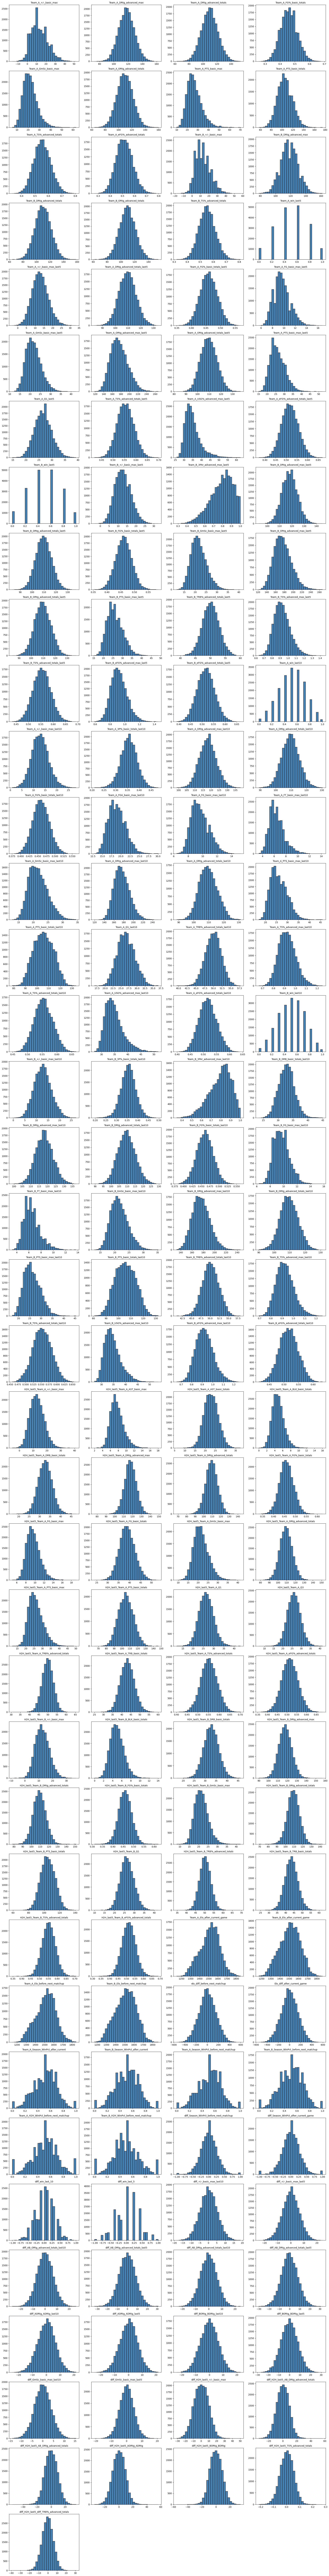

In [60]:
# Number of numerical features
n_features = len(numerical_features)

# Choose grid size (e.g., square layout)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(numerical_features, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df[col].dropna(), bins=30, color='steelblue', edgecolor='black')
    plt.title(col, fontsize=10)
    plt.tight_layout()

plt.show()


In [67]:
x_sequence  = [] 
y_sequence = []
n = 10
grouped = df.groupby('matchup_id')
all_columns = df.drop(columns=['matchup_id', 'date', 'Team_A_win_next']).columns.tolist()
datetime_cols = df.select_dtypes(include=['datetime64', 'datetime']).columns.tolist()
exclude_cols = ['matchup_id', 'date', 'Team_A_win_next'] + datetime_cols

for idx, row in df.iterrows():
    matchup_id = row['matchup_id']
    game_date = row['date']
    past_games = grouped.get_group(matchup_id)
    past_games = past_games[past_games['date'] < game_date]
    if len(past_games) < n:
        continue
    last_n = past_games.tail(n)
    x_seq = last_n.drop(columns=exclude_cols).values
    x_sequence.append(x_seq.astype(np.float32))
    label = last_n.iloc[-1]['Team_A_win_next']
    y_sequence.append(label)

x = np.array(x_sequence, dtype=np.float32)
y = np.array(y_sequence)
all_columns = [col for col in all_columns if col not in datetime_cols]

In [68]:
total_seq = x.shape[0]
games_per_seq = x.shape[1]
features_per_game = x.shape[2] 
print(f'Total sequences = {total_seq}, Games per sequence = {games_per_seq}, Features per game = {features_per_game}')
print(f'Total Team_A_win_next labels = {y.shape[0]}')

Total sequences = 14376, Games per sequence = 10, Features per game = 160
Total Team_A_win_next labels = 14376


In [69]:
train_size = int(0.7 * len(x))  
val_size = int(0.15 * len(x))   
test_size = len(x) - train_size - val_size  

x_train = x[:train_size]
y_train = y[:train_size]
x_val = x[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
x_test = x[train_size+val_size:] 
y_test = y[train_size+val_size:] 

x_train_flat = x_train.reshape(-1, x_train.shape[-1])  # shape: (total sequences * games, num features)
df_x_train_flat = pd.DataFrame(x_train_flat, columns=all_columns)
binary_cols = [col for col in df_x_train_flat.columns if df_x_train_flat[col].nunique() == 2]
exclude_cols = set(binary_cols + ['Team_A', 'Team_B'])
normalize_cols = [col for col in all_columns if col not in exclude_cols]
normalize_indices = [all_columns.index(col) for col in normalize_cols]

mean = df_x_train_flat[normalize_cols].mean().values
std = df_x_train_flat[normalize_cols].std().values

x_train[:, :, normalize_indices] = (x_train[:, :, normalize_indices] - mean) / std
x_val[:, :, normalize_indices] = (x_val[:, :, normalize_indices] - mean) / std
x_test[:, :, normalize_indices] = (x_test[:, :, normalize_indices] - mean) / std

np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

In [70]:
print(x_train.shape, x_train.dtype)
print(type(x_train[0]))

(10063, 10, 160) float32
<class 'numpy.ndarray'>


In [71]:
non_numeric_cols = []
for col in range(x_train[0].shape[-1]):
    try:
        col_values = [seq[:, col] for seq in x_train]
        np.concatenate(col_values).astype(float)  # try forcing to float
    except Exception:
        non_numeric_cols.append(col)

print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: []
